In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test_image_dataset.npy
/kaggle/input/val_image_dataset.npy
/kaggle/input/mask_test_image_dataset.npy
/kaggle/input/mask_val_image_dataset.npy
/kaggle/input/mask_train_image_dataset.npy
/kaggle/input/train_image_dataset.npy


In [2]:
!pip install patchify
!pip install -U -q segmentation-models

In [3]:
# import os

In [4]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [5]:

import cv2
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.math import log , reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.callbacks import History
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

2024-04-10 08:26:12.736132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 08:26:12.736250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 08:26:12.892171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [7]:
print("TensorFlow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, running on CPU instead.")

TensorFlow version: 2.15.0
Pandas version: 2.2.1
Numpy version: 1.26.4
2 Physical GPUs, 2 Logical GPUs


In [8]:
save_train_image_dataset_path = '/kaggle/input/train_image_dataset.npy'
save_val_image_dataset_path = '/kaggle/input/val_image_dataset.npy'
save_test_image_dataset_path = '/kaggle/input/test_image_dataset.npy'
save_train_mask_image_dataset_path = '/kaggle/input/mask_train_image_dataset.npy'
save_val_mask_image_dataset_path = '/kaggle/input/mask_val_image_dataset.npy'
save_test_mask_image_dataset_path = '/kaggle/input/mask_test_image_dataset.npy'

In [9]:
X_train = np.load(save_train_image_dataset_path, mmap_mode='c')
X_val = np.load(save_val_image_dataset_path, mmap_mode='c')
X_test = np.load(save_test_image_dataset_path, mmap_mode='c')
y_train = np.load(save_train_mask_image_dataset_path, mmap_mode='c')
y_val = np.load(save_val_mask_image_dataset_path, mmap_mode='c')
y_test = np.load(save_test_mask_image_dataset_path, mmap_mode='c')

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [11]:
def _normalize(X_batch, y_batch):
  X_batch = tf.cast(X_batch, tf.float32)
  y_batch = tf.cast(y_batch, tf.float32)
  return X_batch, y_batch

train_dataset = train_dataset.batch(16).map(_normalize)
val_dataset = val_dataset.batch(16).map(_normalize)


In [12]:
checkpoint_path = "dice_loss_resnet34_backbone_updated/cp.weights.h5"

In [13]:
# BACKBONE1 = 'resnet34'
# preprocess_input = sm.get_preprocessing(BACKBONE1)

# def preprocess_pyfunc(x, y):
#     x = tf.py_function(preprocess_input, [x], tf.float32)
#     x.set_shape([None, None, None, 3]) # Set the shape explicitly
#     return x, y

# train_dataset = train_dataset.map(preprocess_pyfunc)
# val_dataset = val_dataset.map(preprocess_pyfunc)

BACKBONE1 = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE1)

# preprocess input
train_dataset = preprocess_input(train_dataset)
val_dataset = preprocess_input(val_dataset)


In [14]:
model = sm.Unet('resnet34', classes=5, activation='softmax')
model.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score],)

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# gpus = tf.config.list_logical_devices('GPU')
# strategy = tf.distribute.MirroredStrategy(gpus)

In [16]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=True,
                                             verbose=1)
]


# model = tf.keras.models.load_model('my_model_with_batch_image.keras')
history = model.fit(
   train_dataset,
   epochs=150,
   validation_data=val_dataset,
   callbacks=callbacks,
)

Epoch 1/150


I0000 00:00:1712737692.924670      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - iou_score: 0.3825 - loss: 0.5121
Epoch 1: val_loss improved from inf to 0.80131, saving model to dice_loss_resnet34_backbone_updated/cp.weights.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 183s 528ms/step - iou_score: 0.3831 - loss: 0.5115 - val_iou_score: 0.1184 - val_loss: 0.8013
Epoch 2/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - iou_score: 0.5793 - loss: 0.3026
Epoch 2: val_loss improved from 0.80131 to 0.28847, saving model to dice_loss_resnet34_backbone_updated/cp.weights.h5
195/195 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - iou_score: 0.5794 - loss: 0.3025 - val_iou_score: 0.6068 - val_loss: 0.2885
Epoch 3/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - iou_score: 0.6127 - loss: 0.2709
Epoch 3: val_loss did not improve from 0.28847
195/195 ━━━━━━━━━━━━━━━━━━━━ 47s 239ms/step - iou_score: 0.6127 - loss: 0.2708 - val_iou_score: 0.5222 - val_loss: 0.3586
Epoch 4/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - iou_score: 0.6168 - loss: 0.2671
Epoch 

In [27]:
# model.load_weights(checkpoint_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/tmp/ipykernel_34/2597055290.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(50, 12.5))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


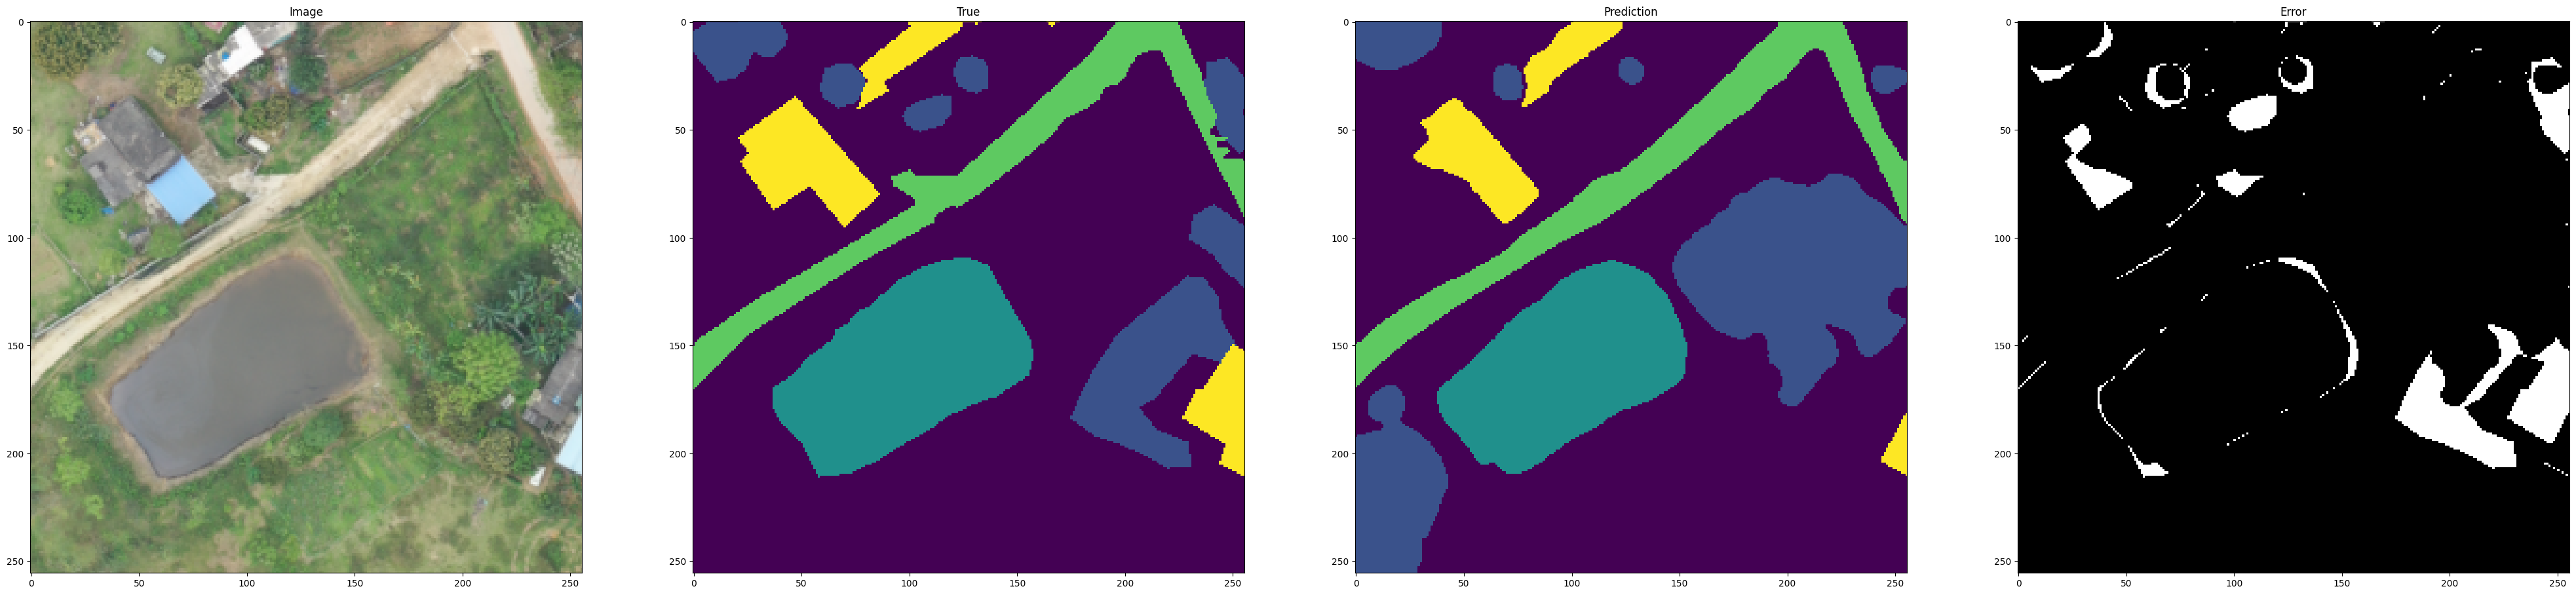

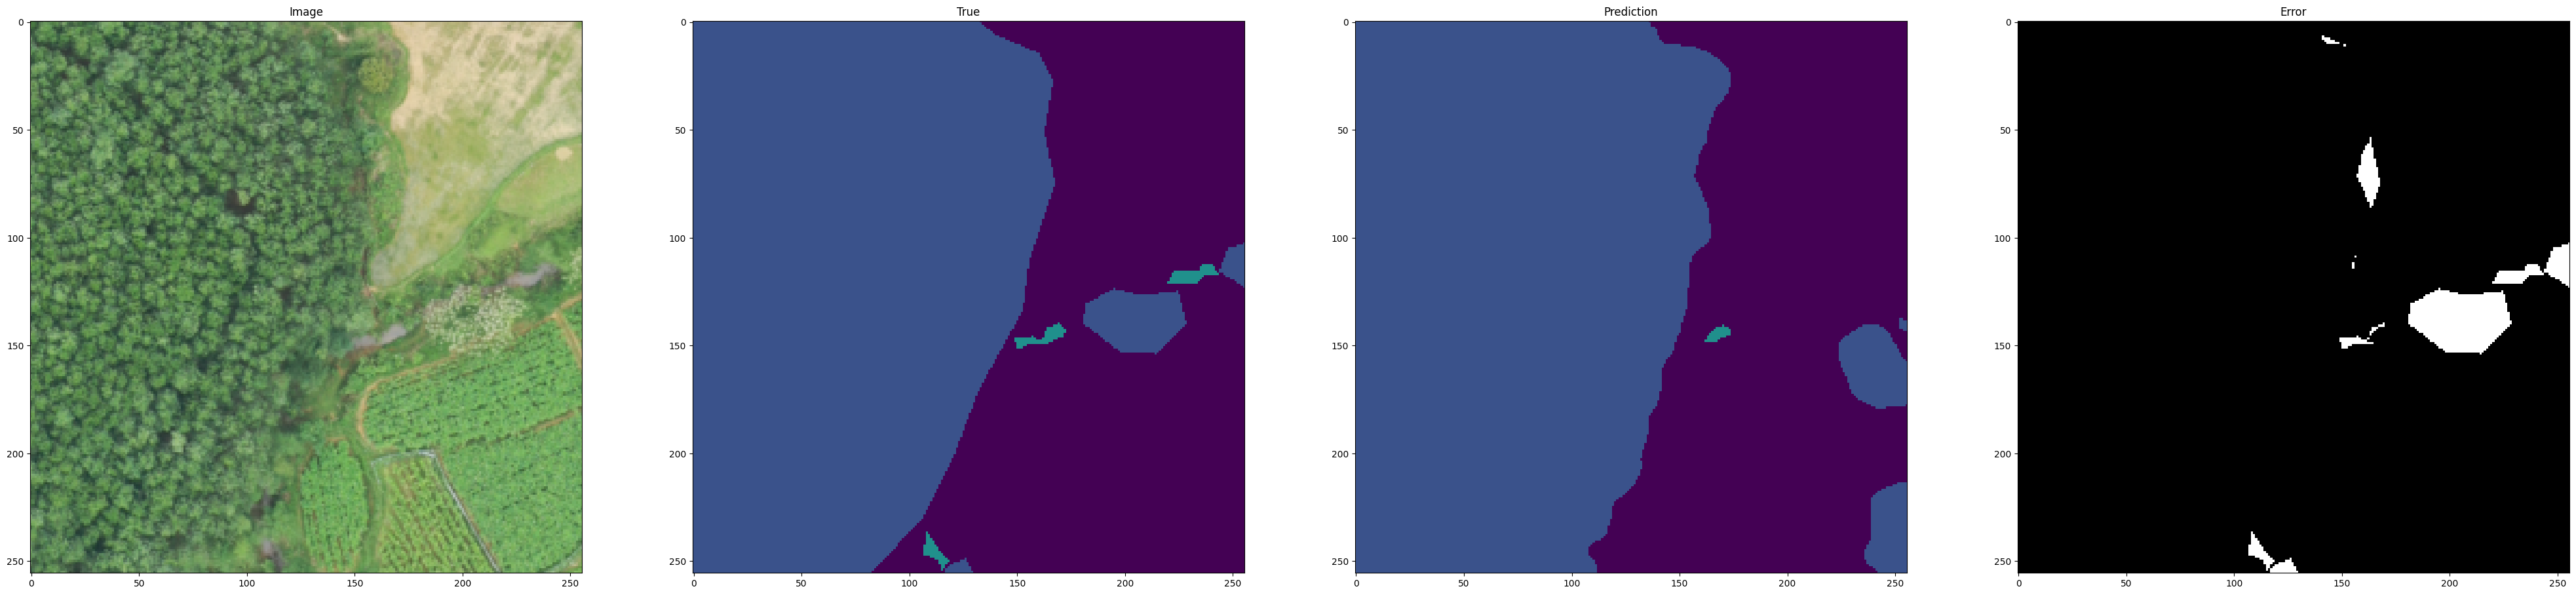

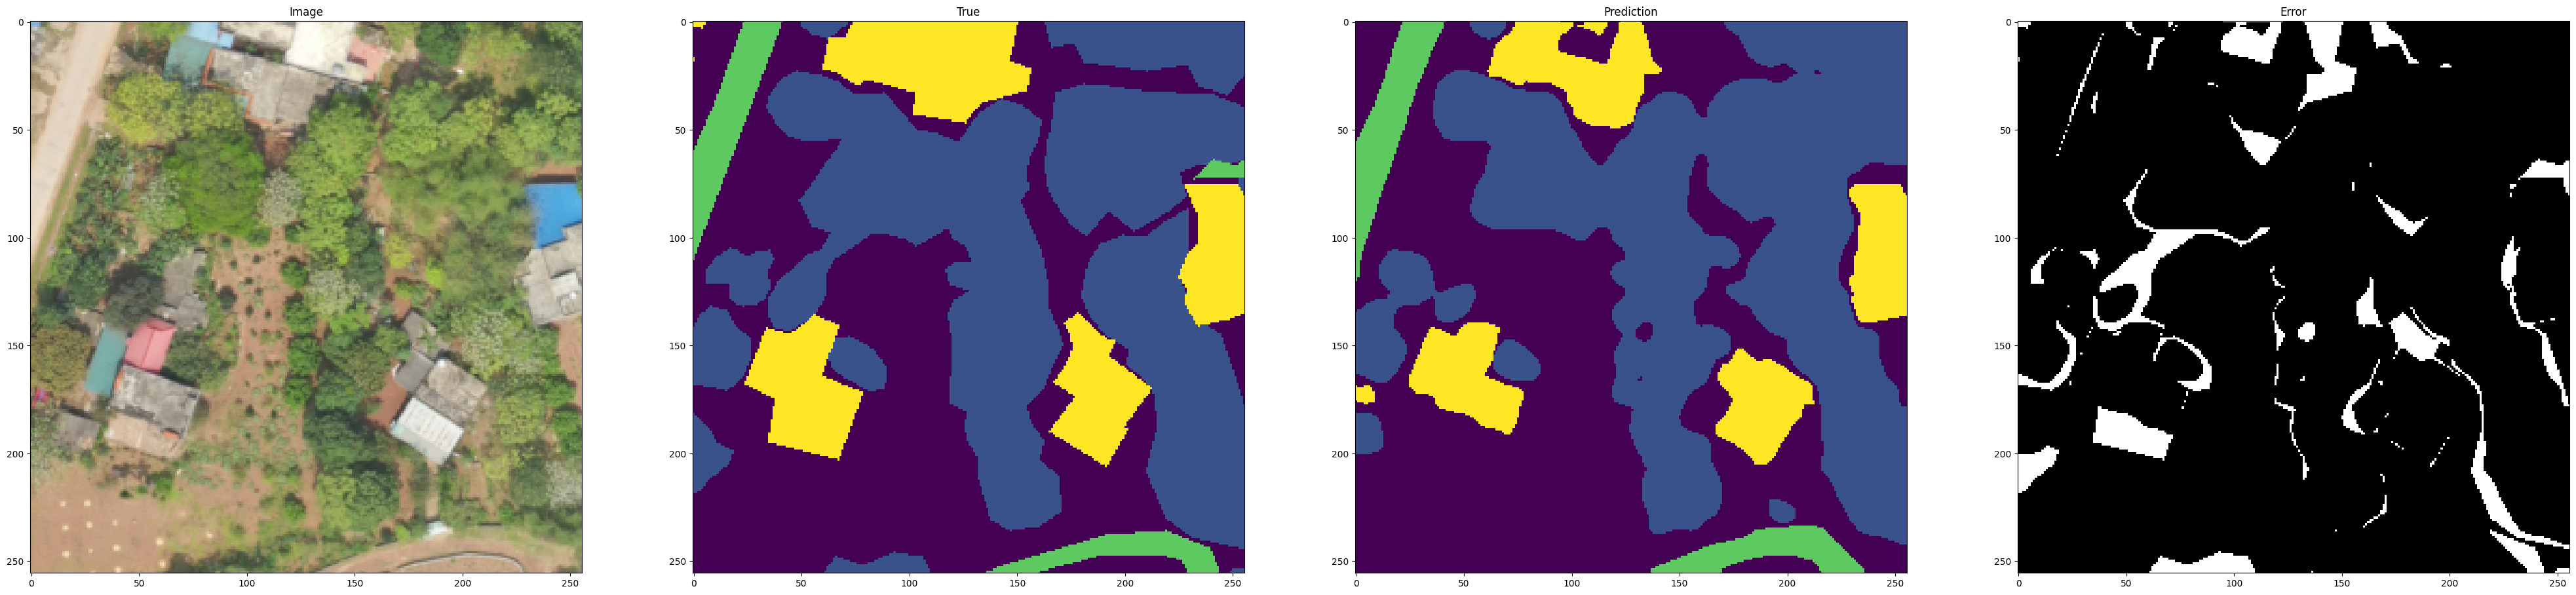

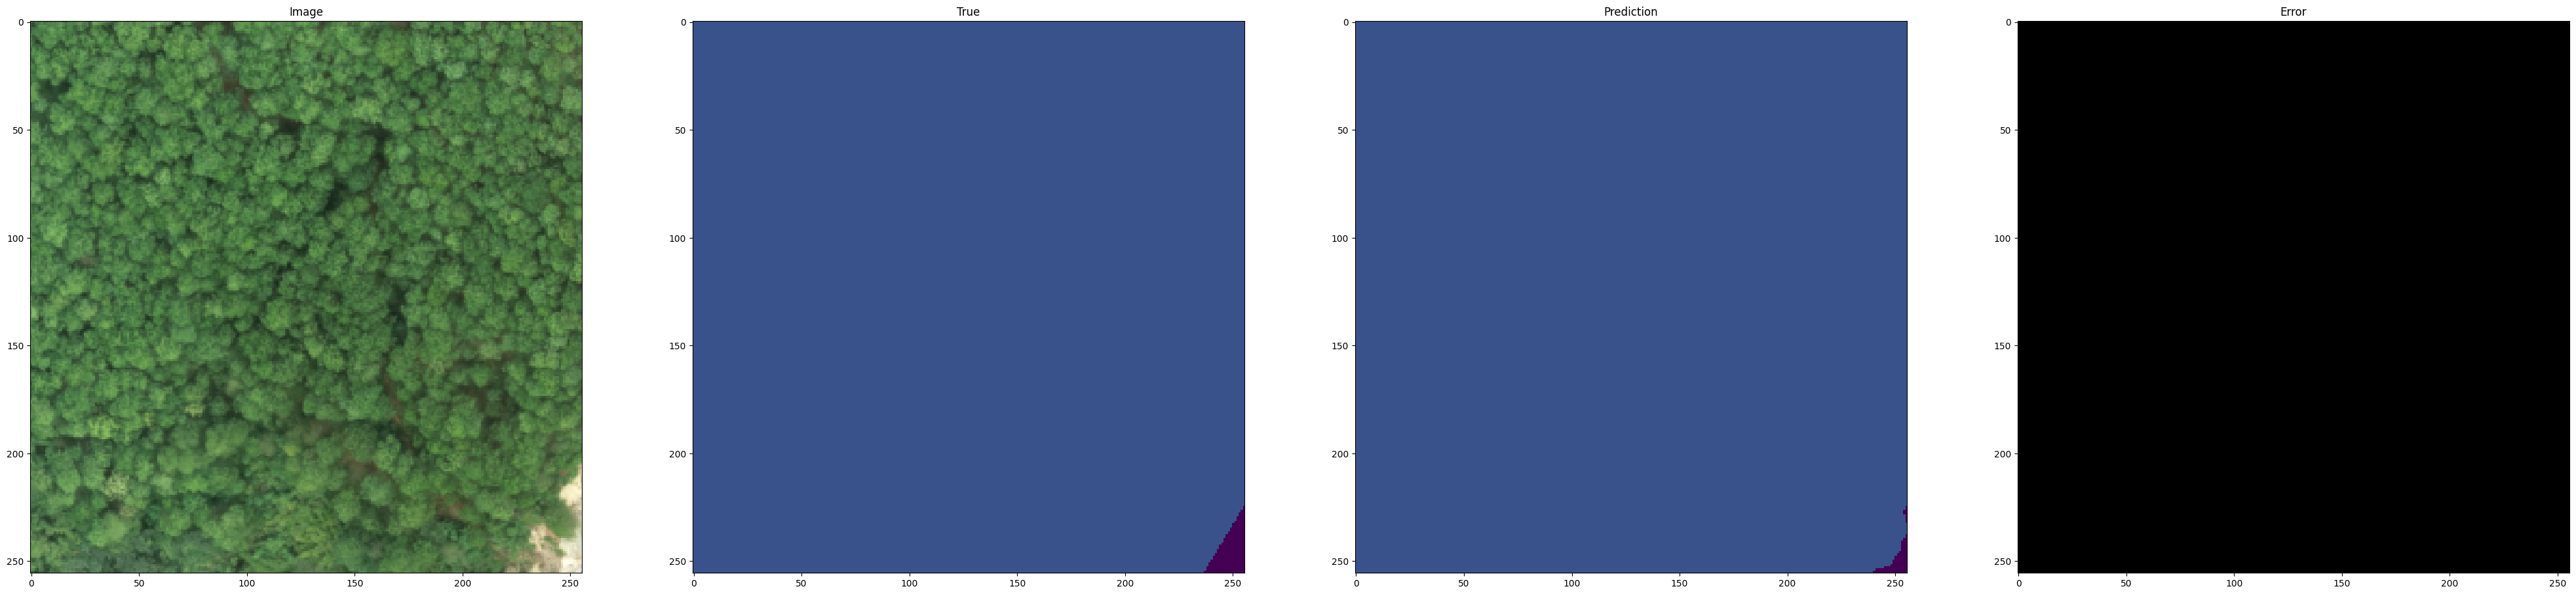

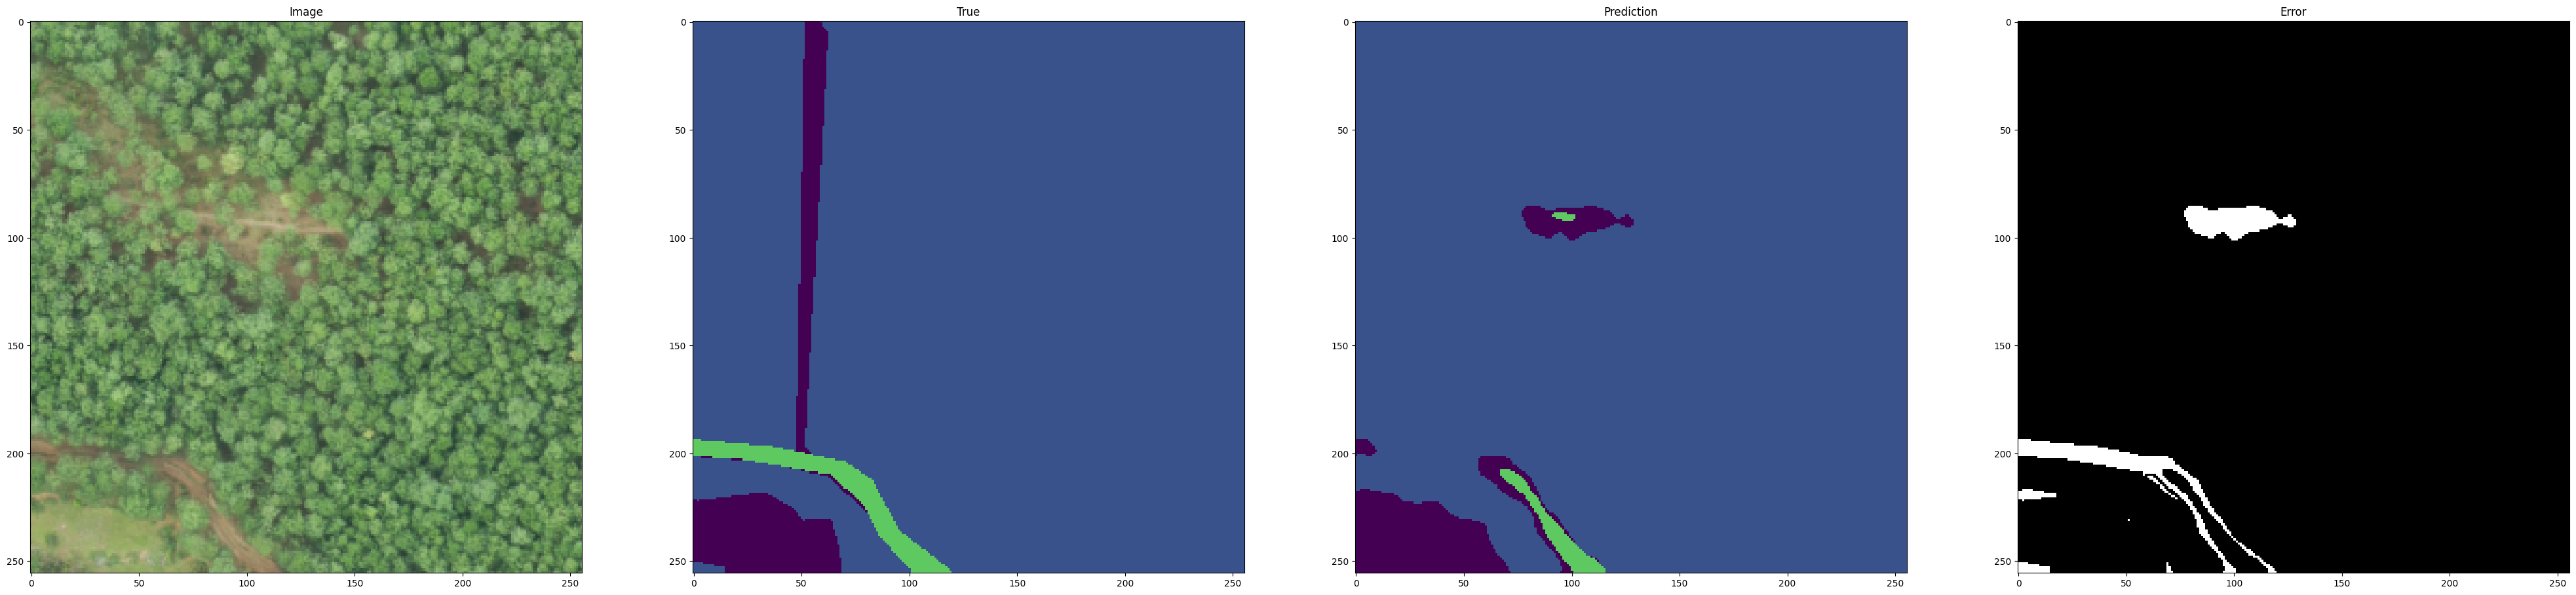

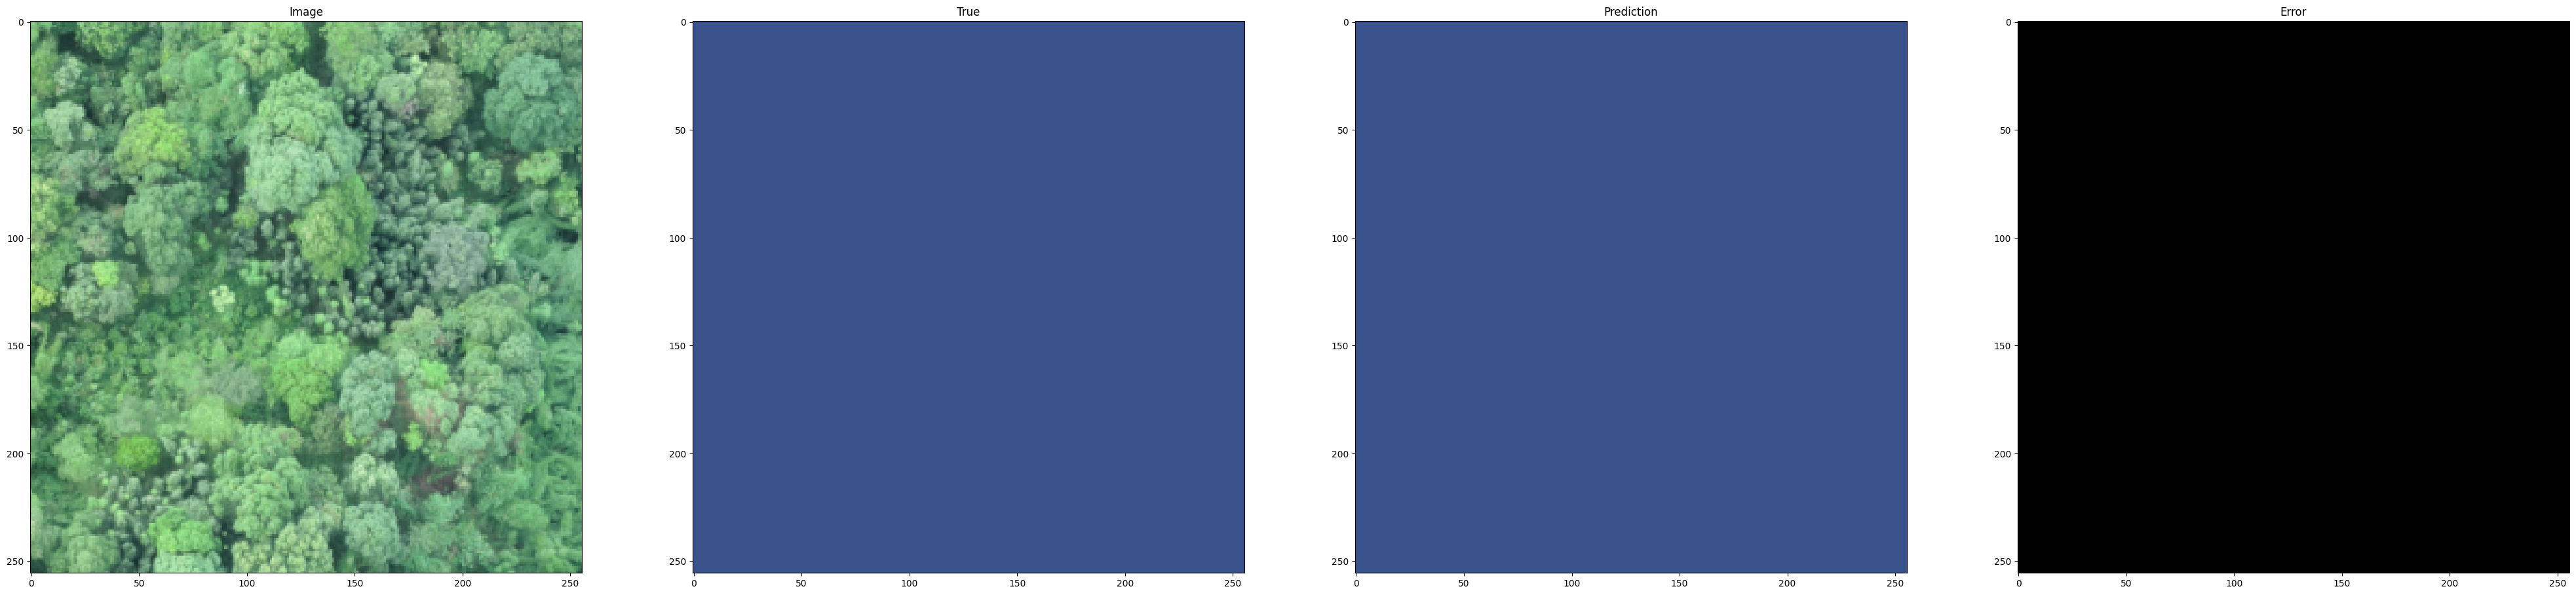

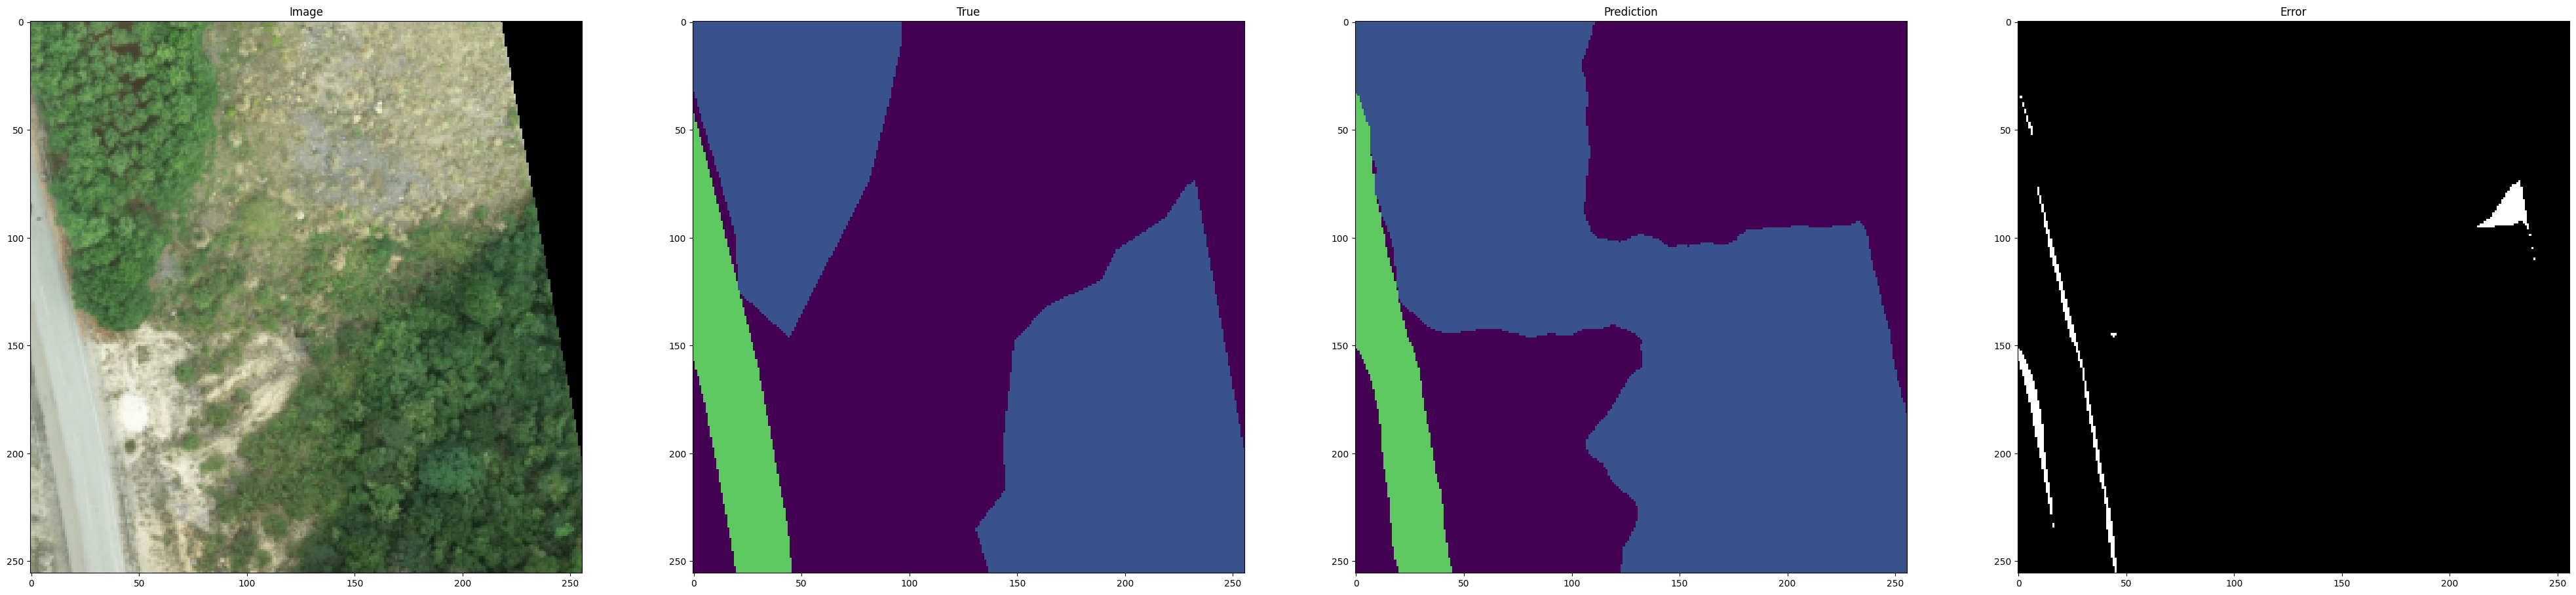

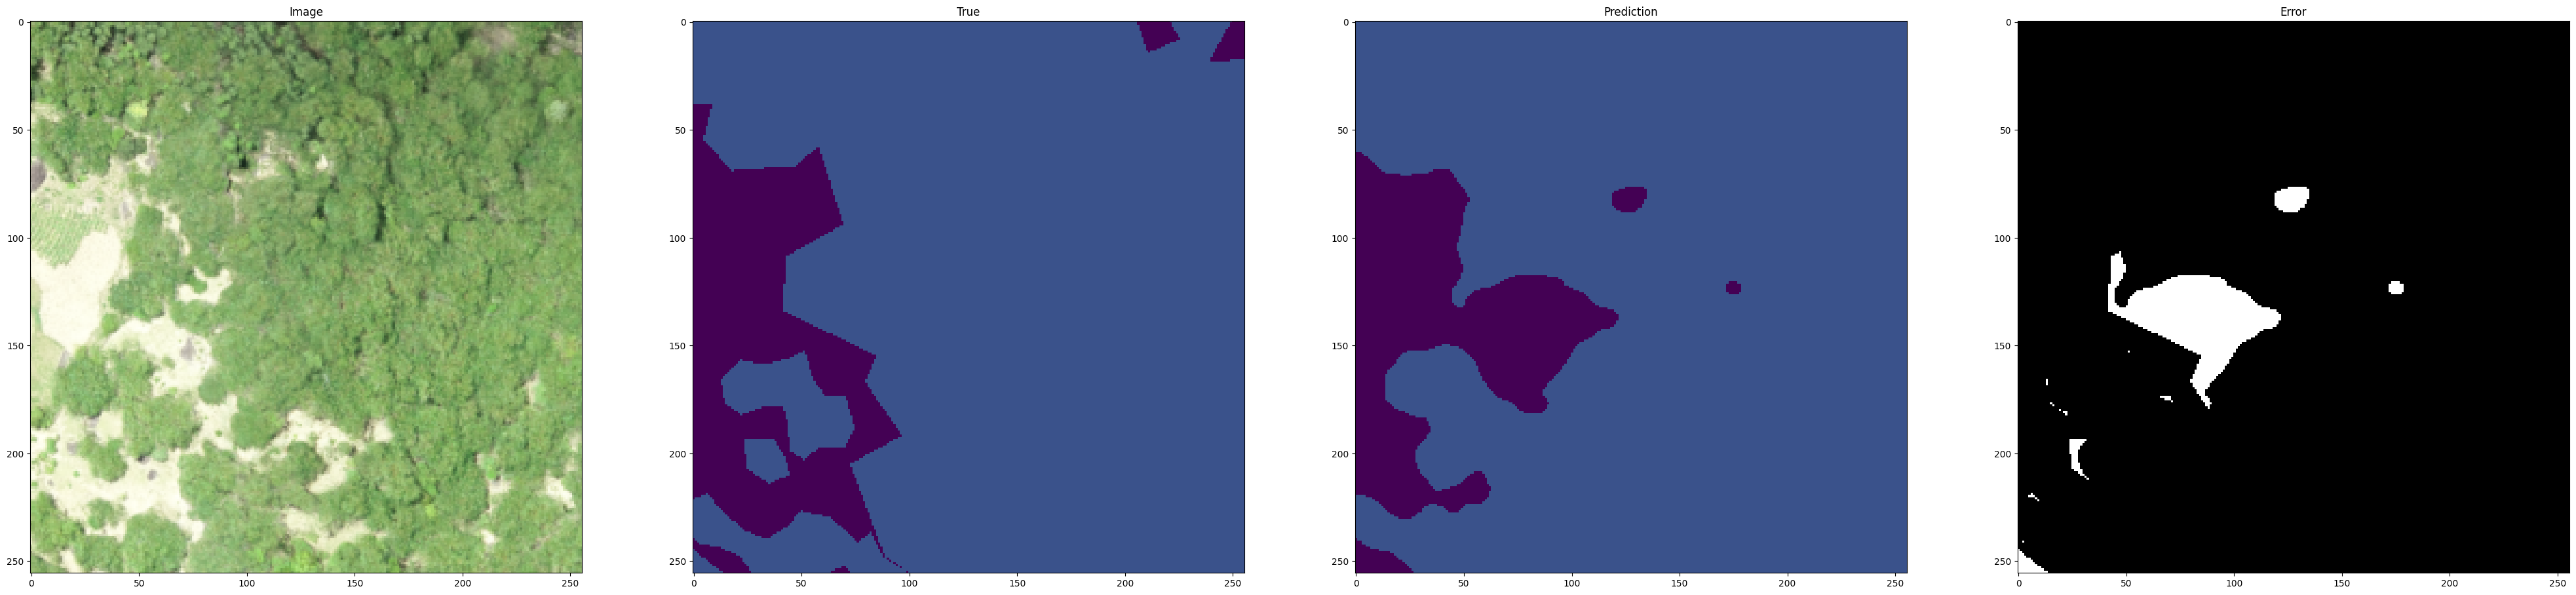

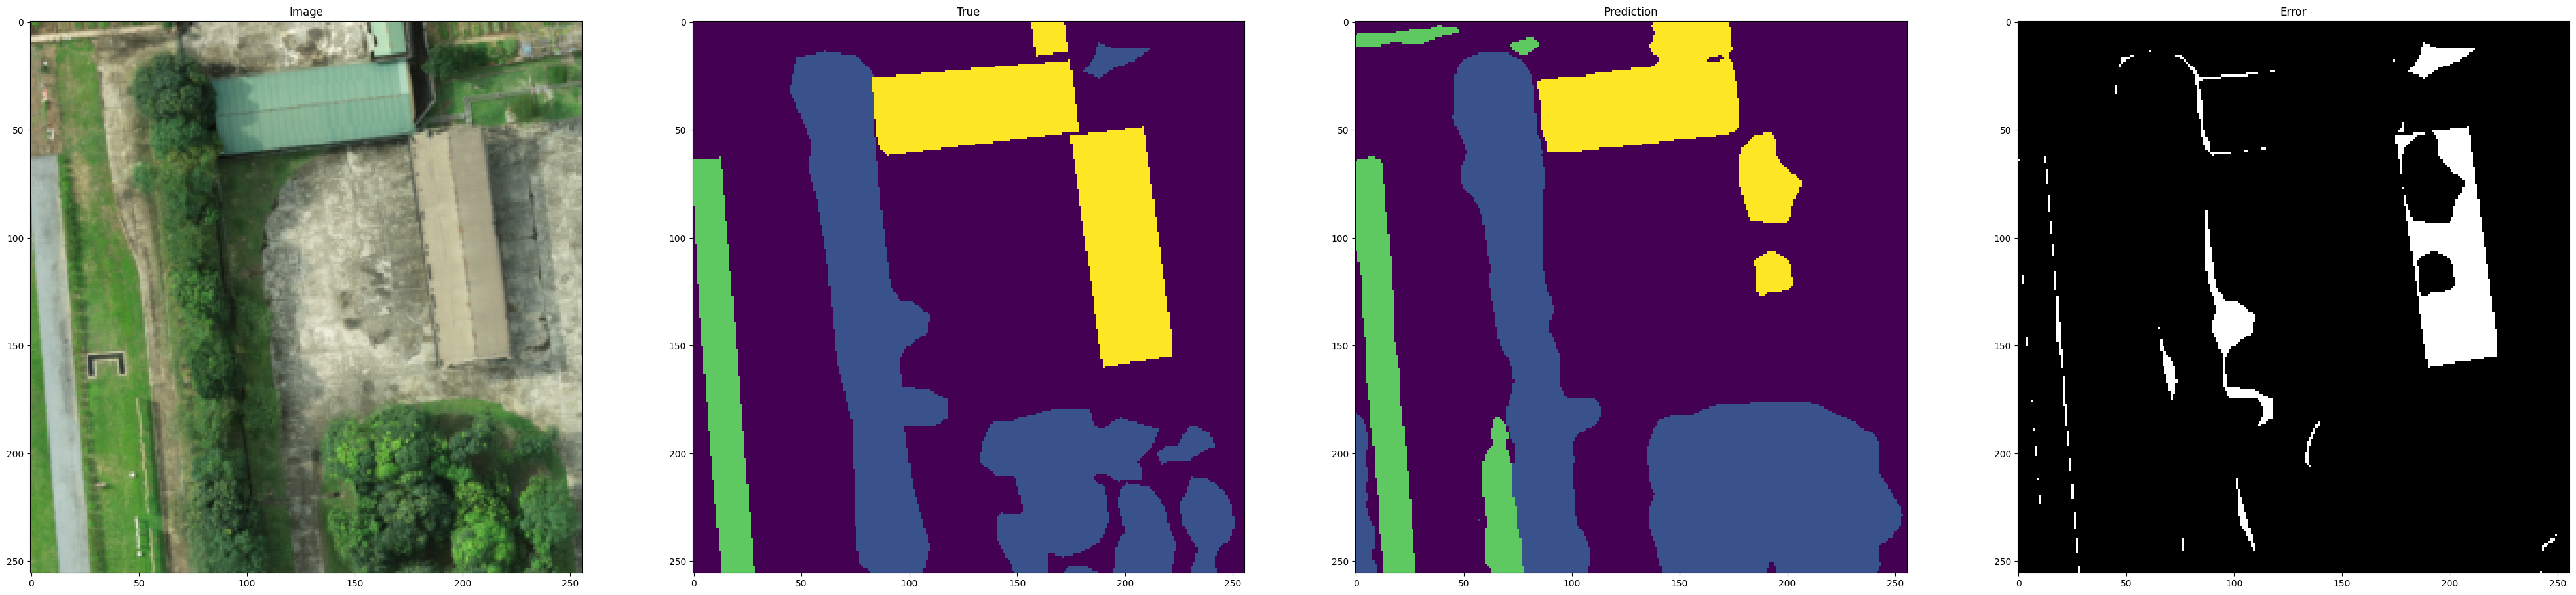

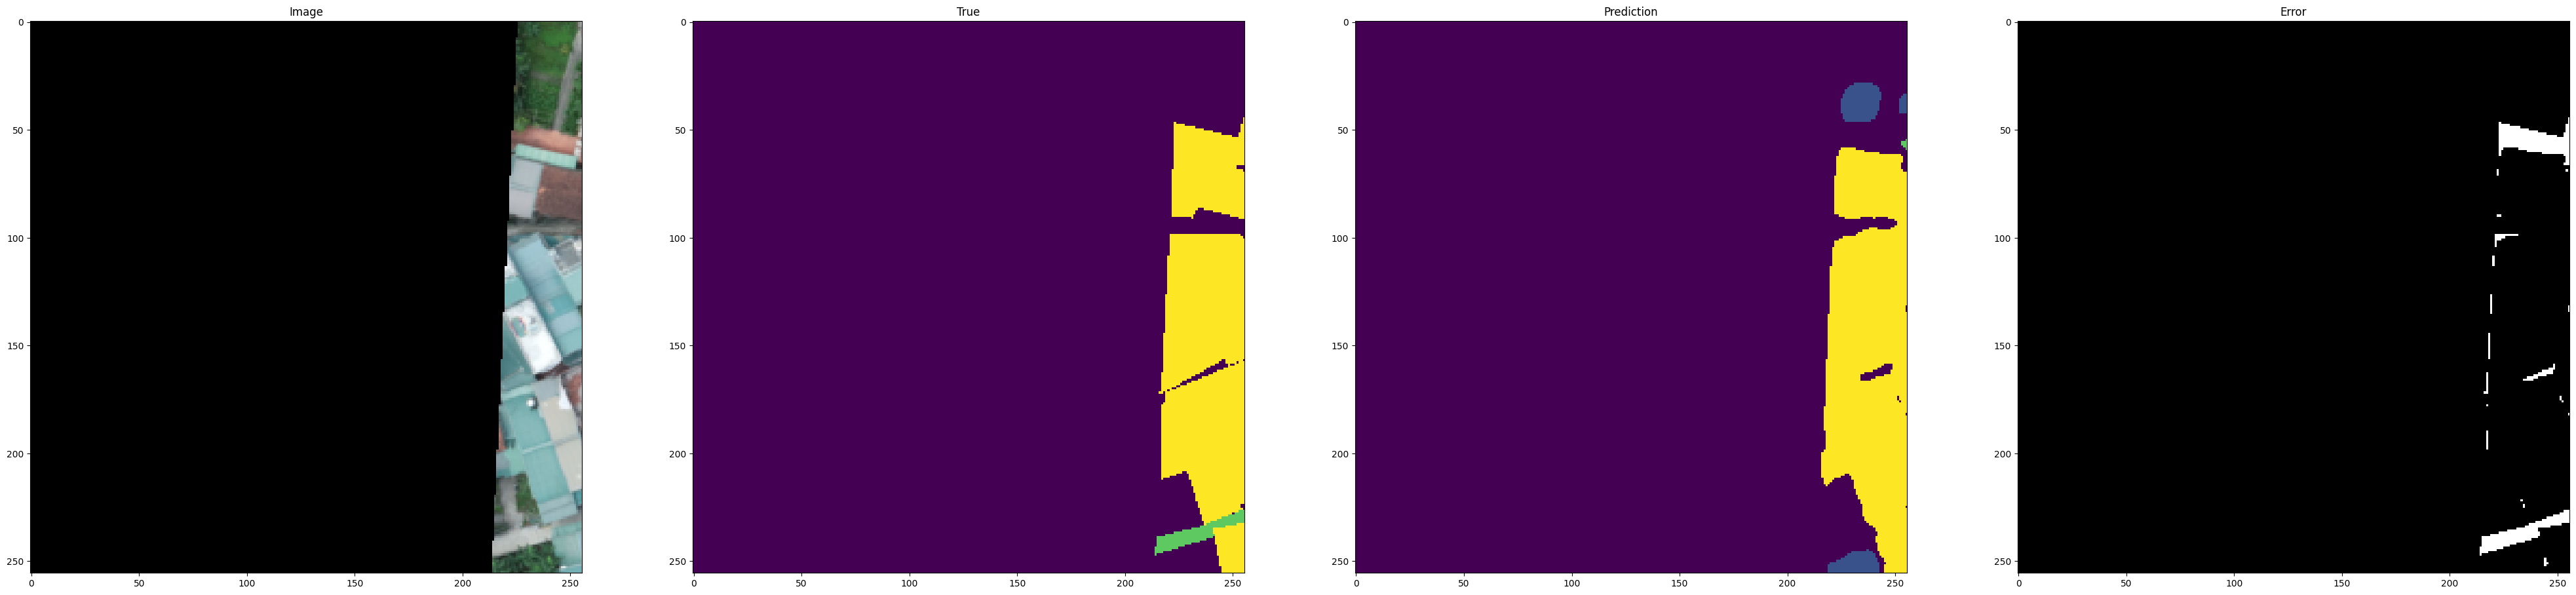

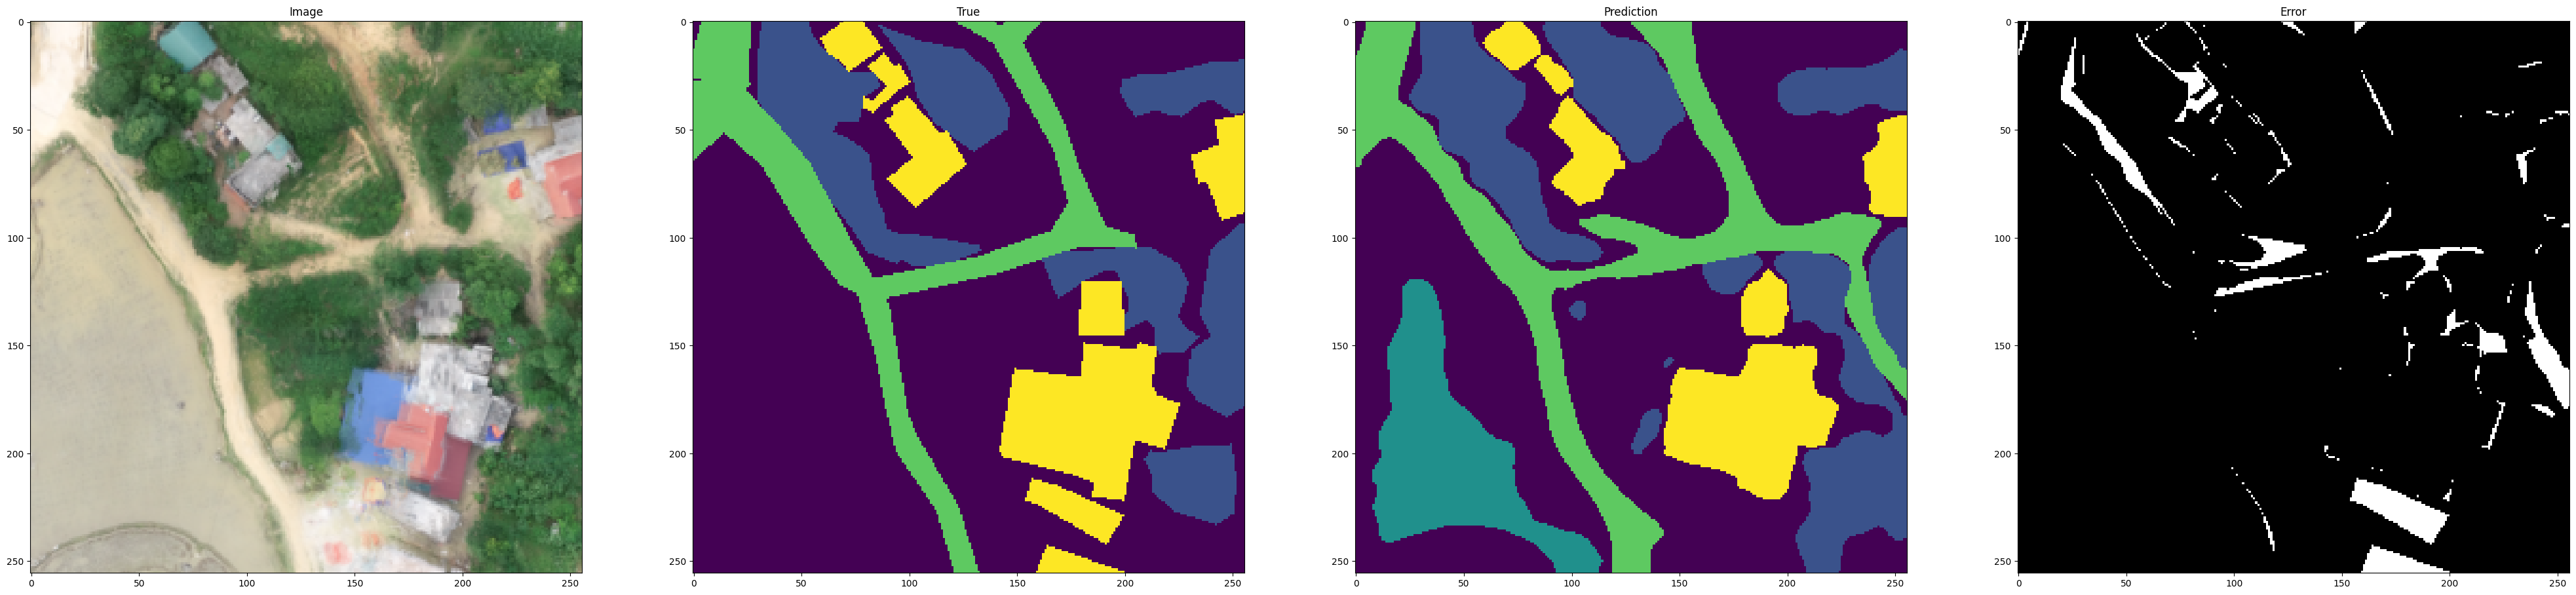

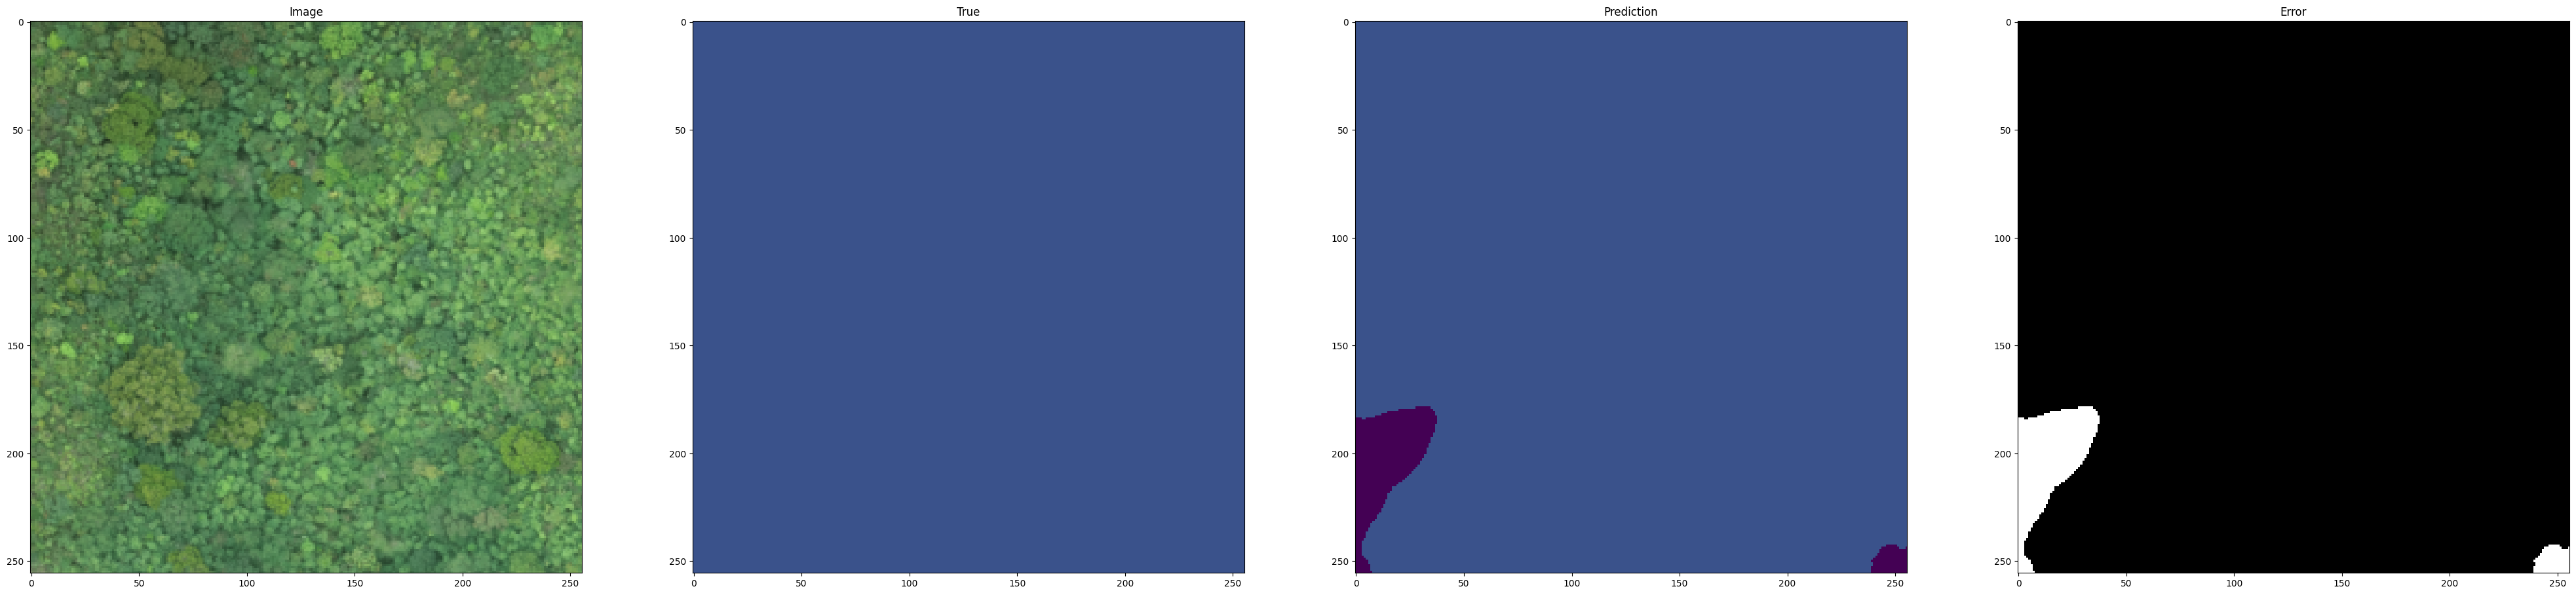

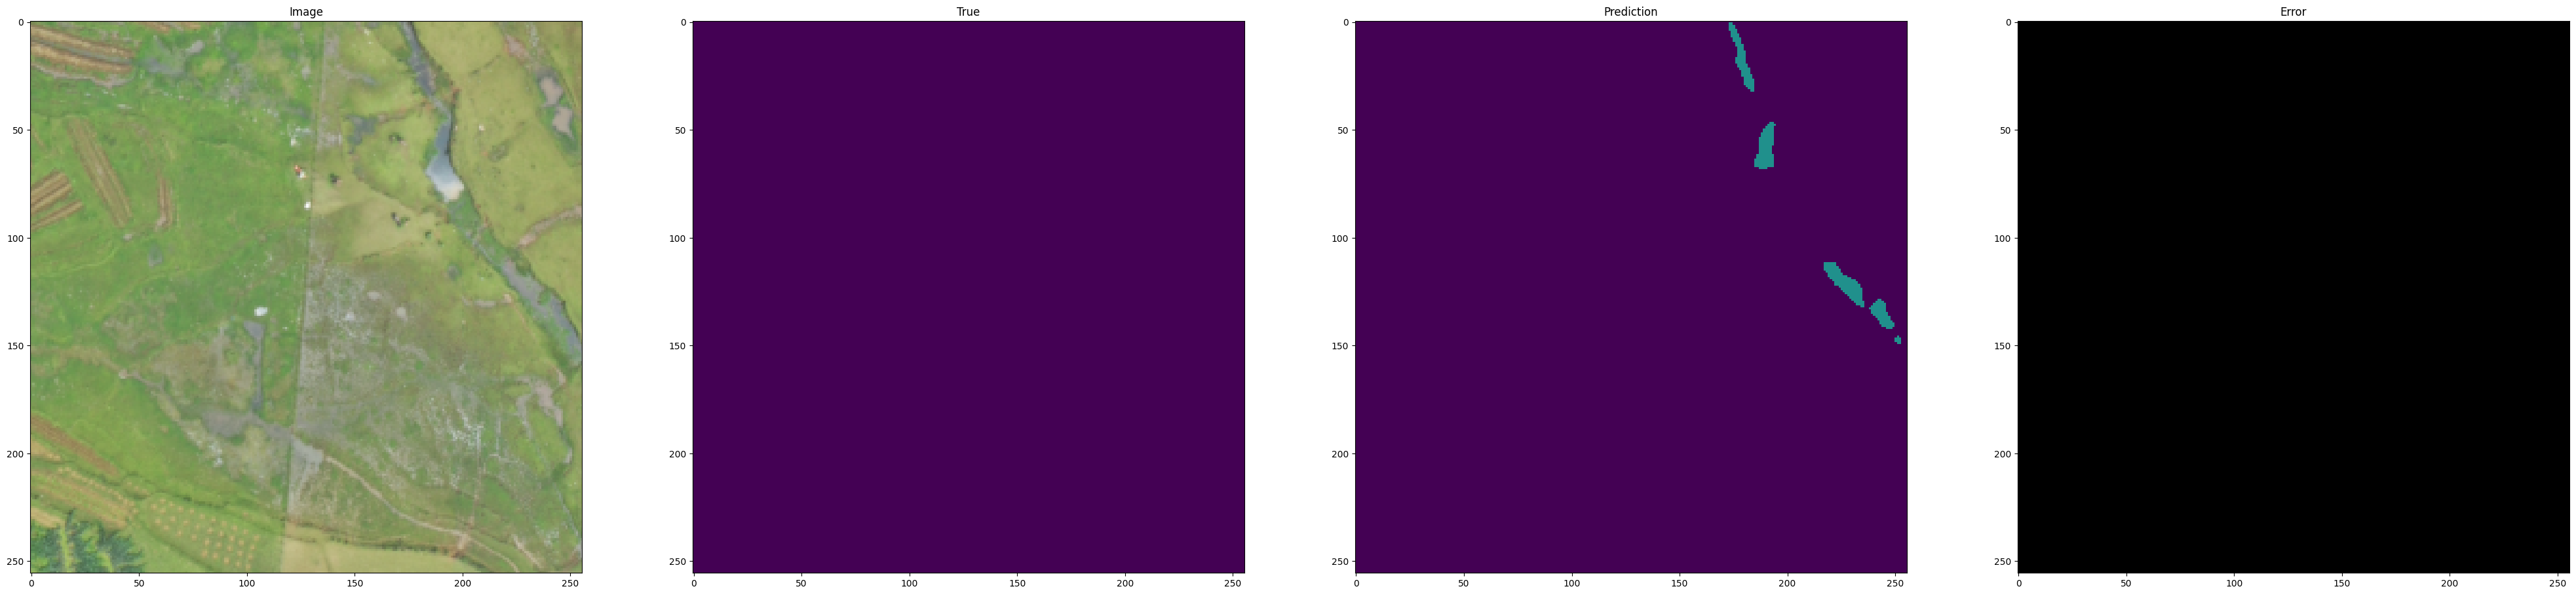

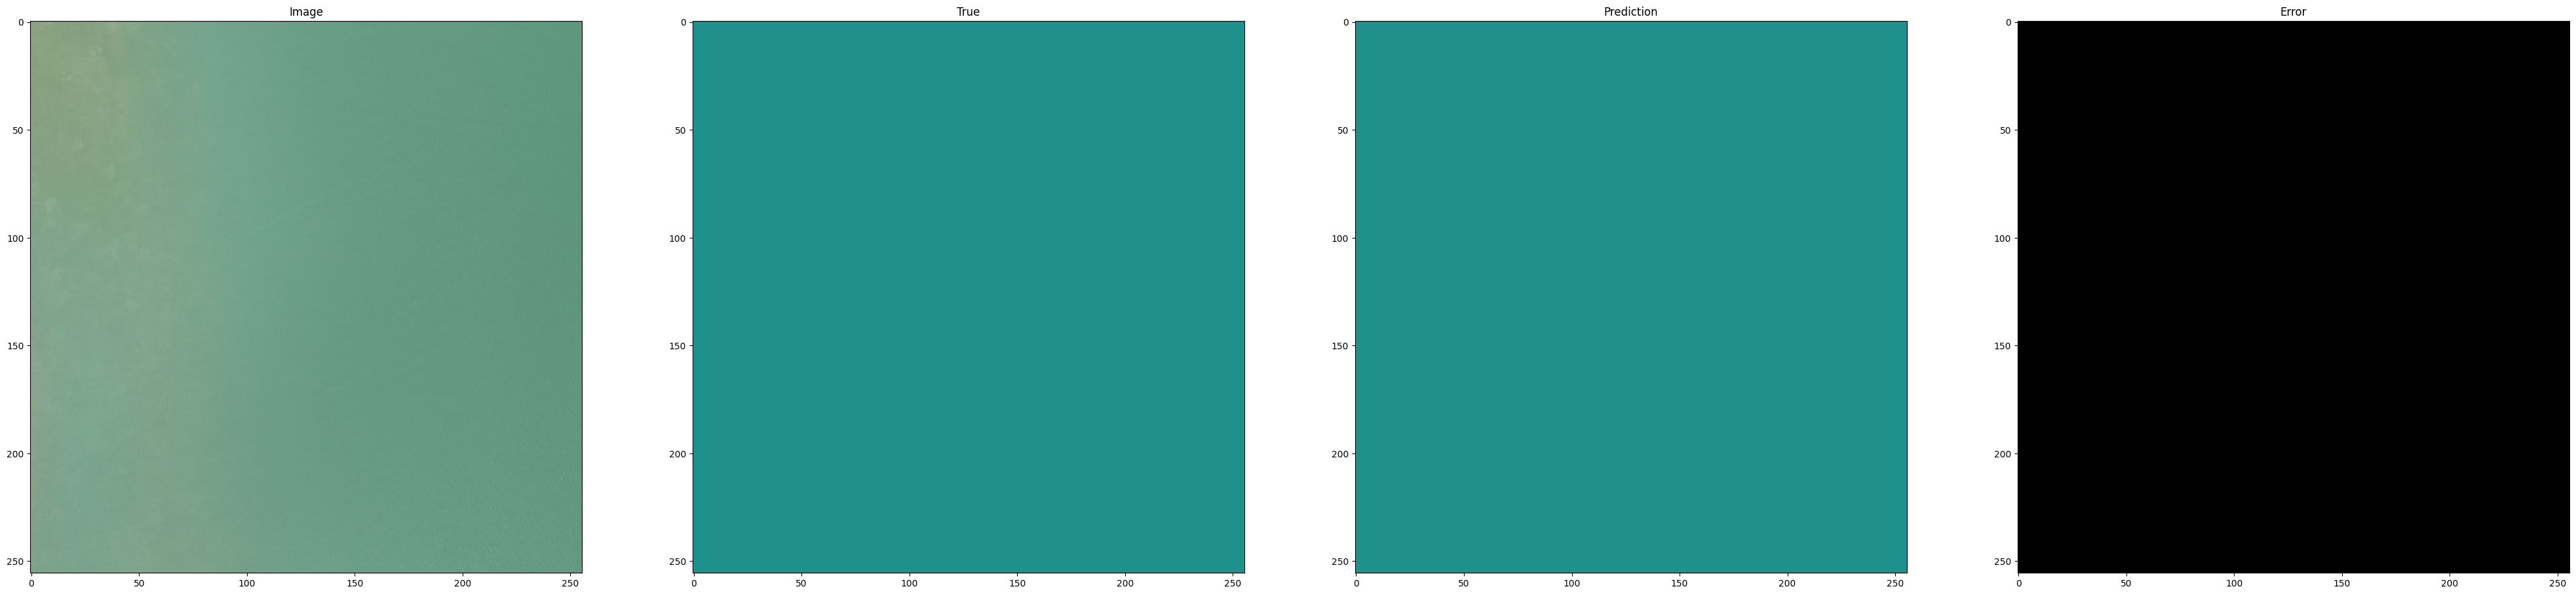

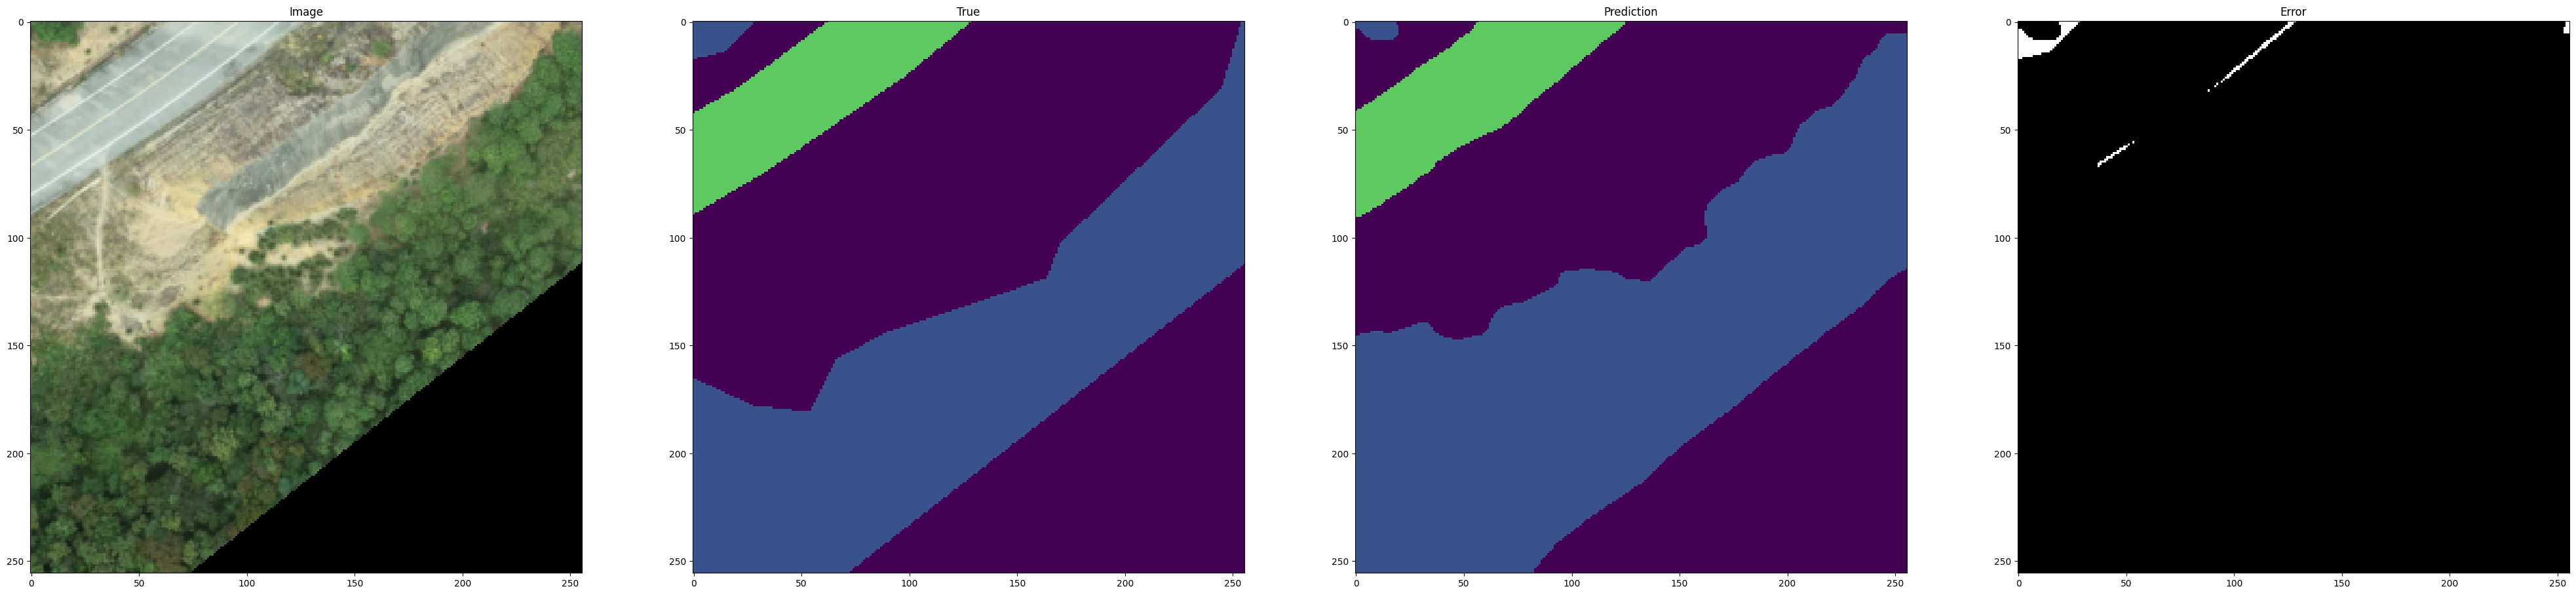

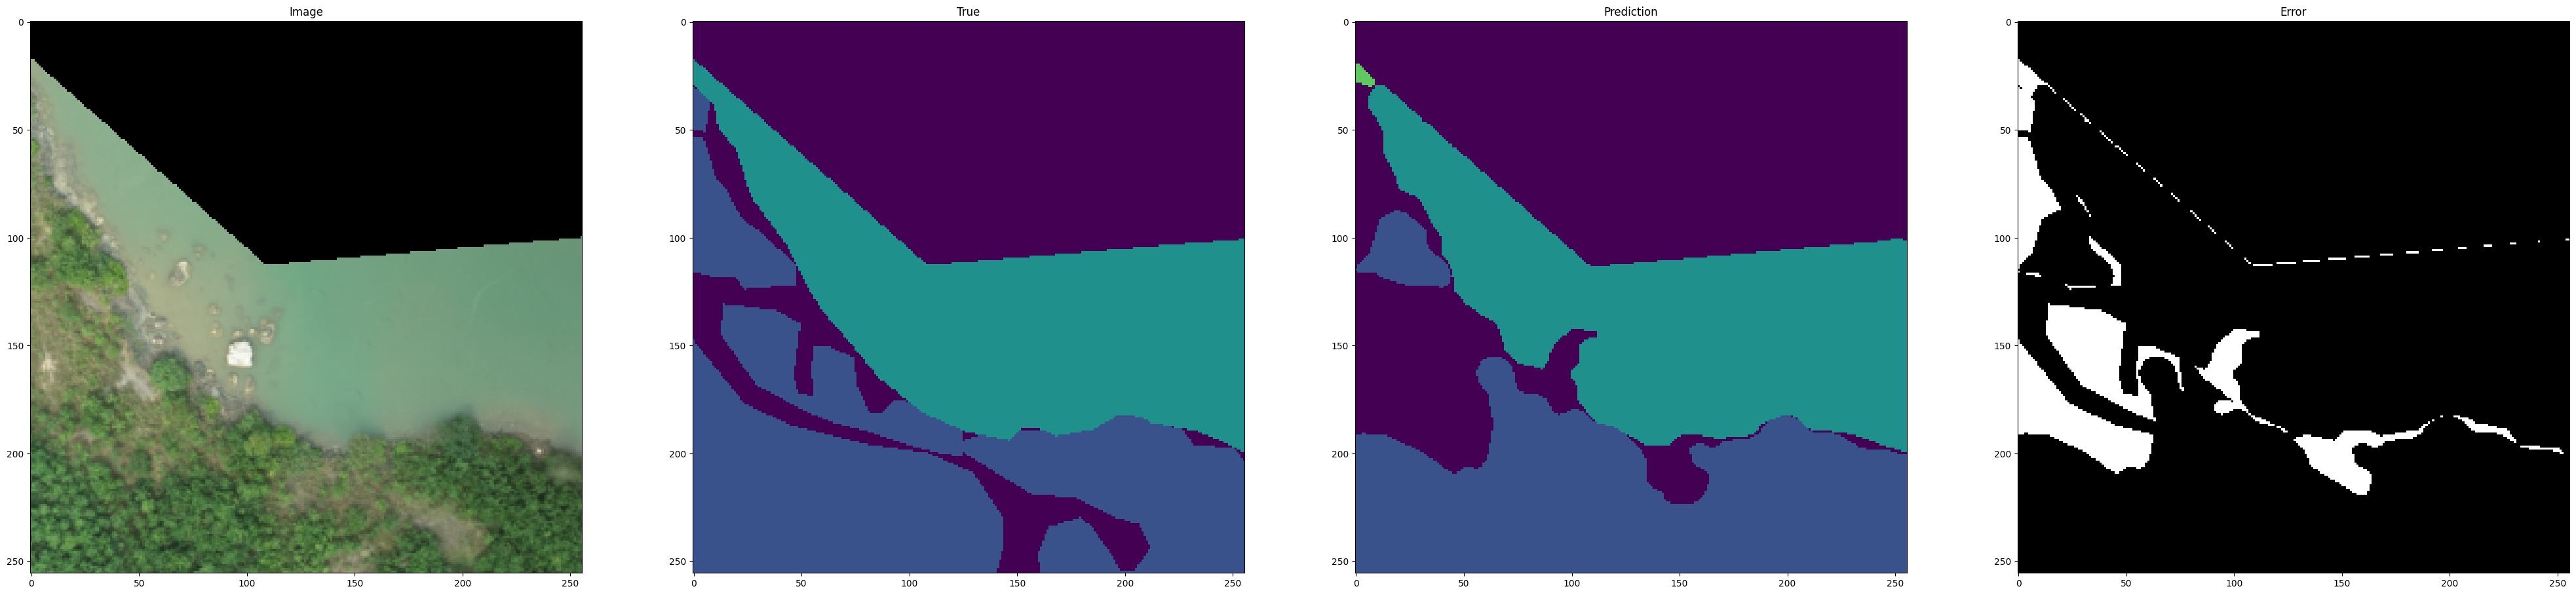

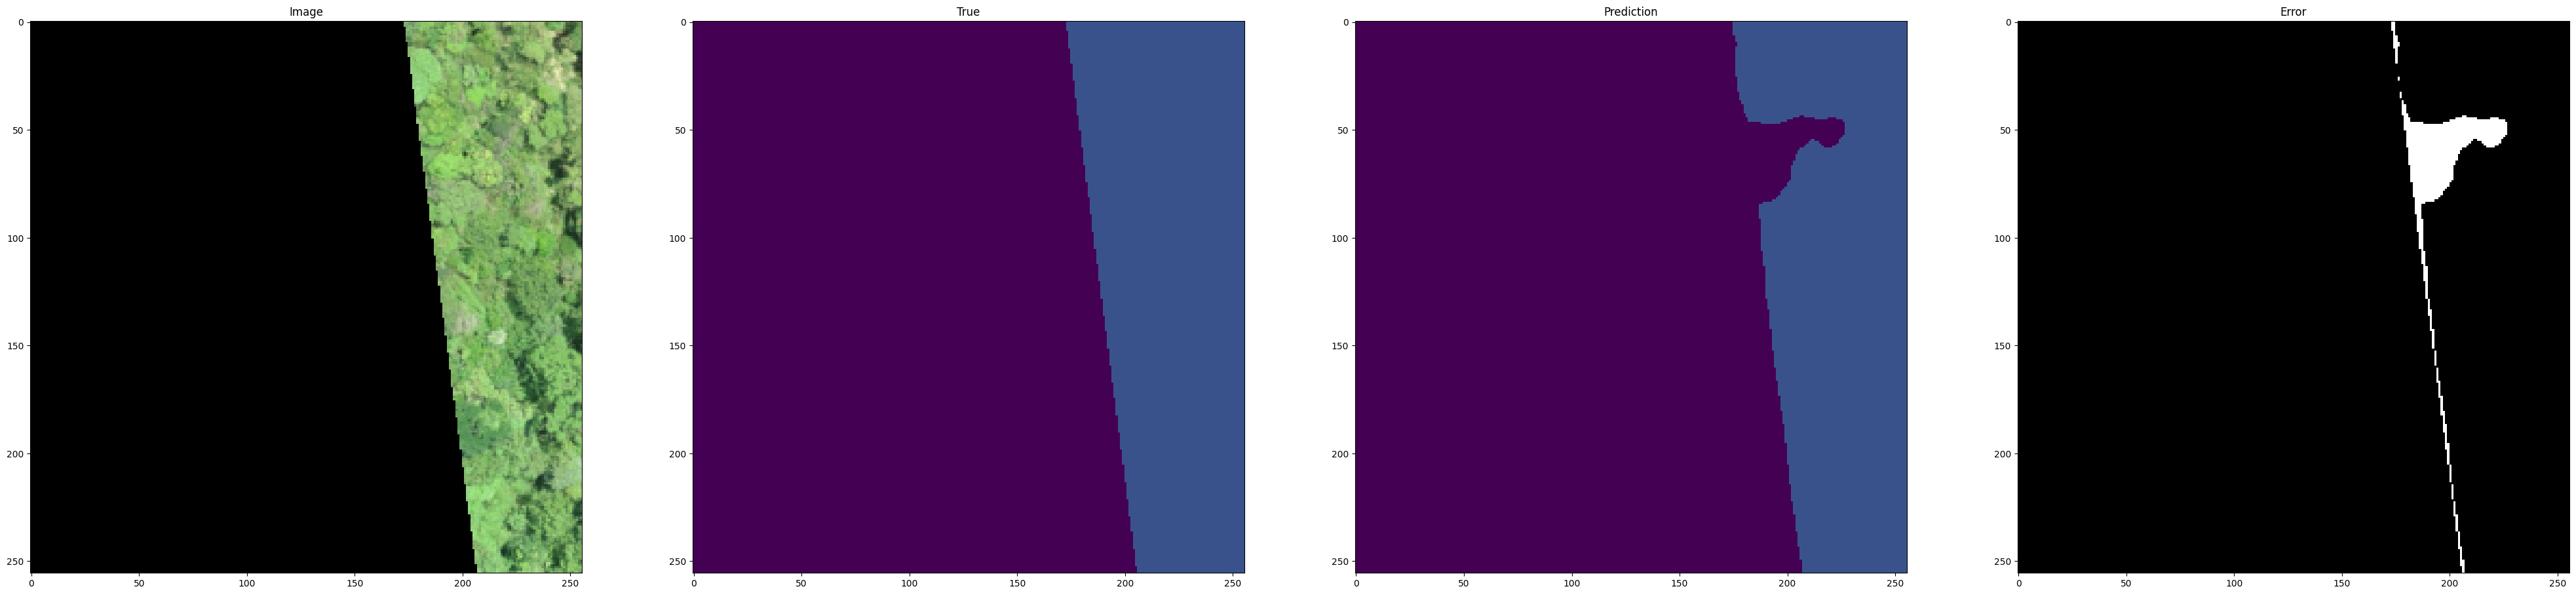

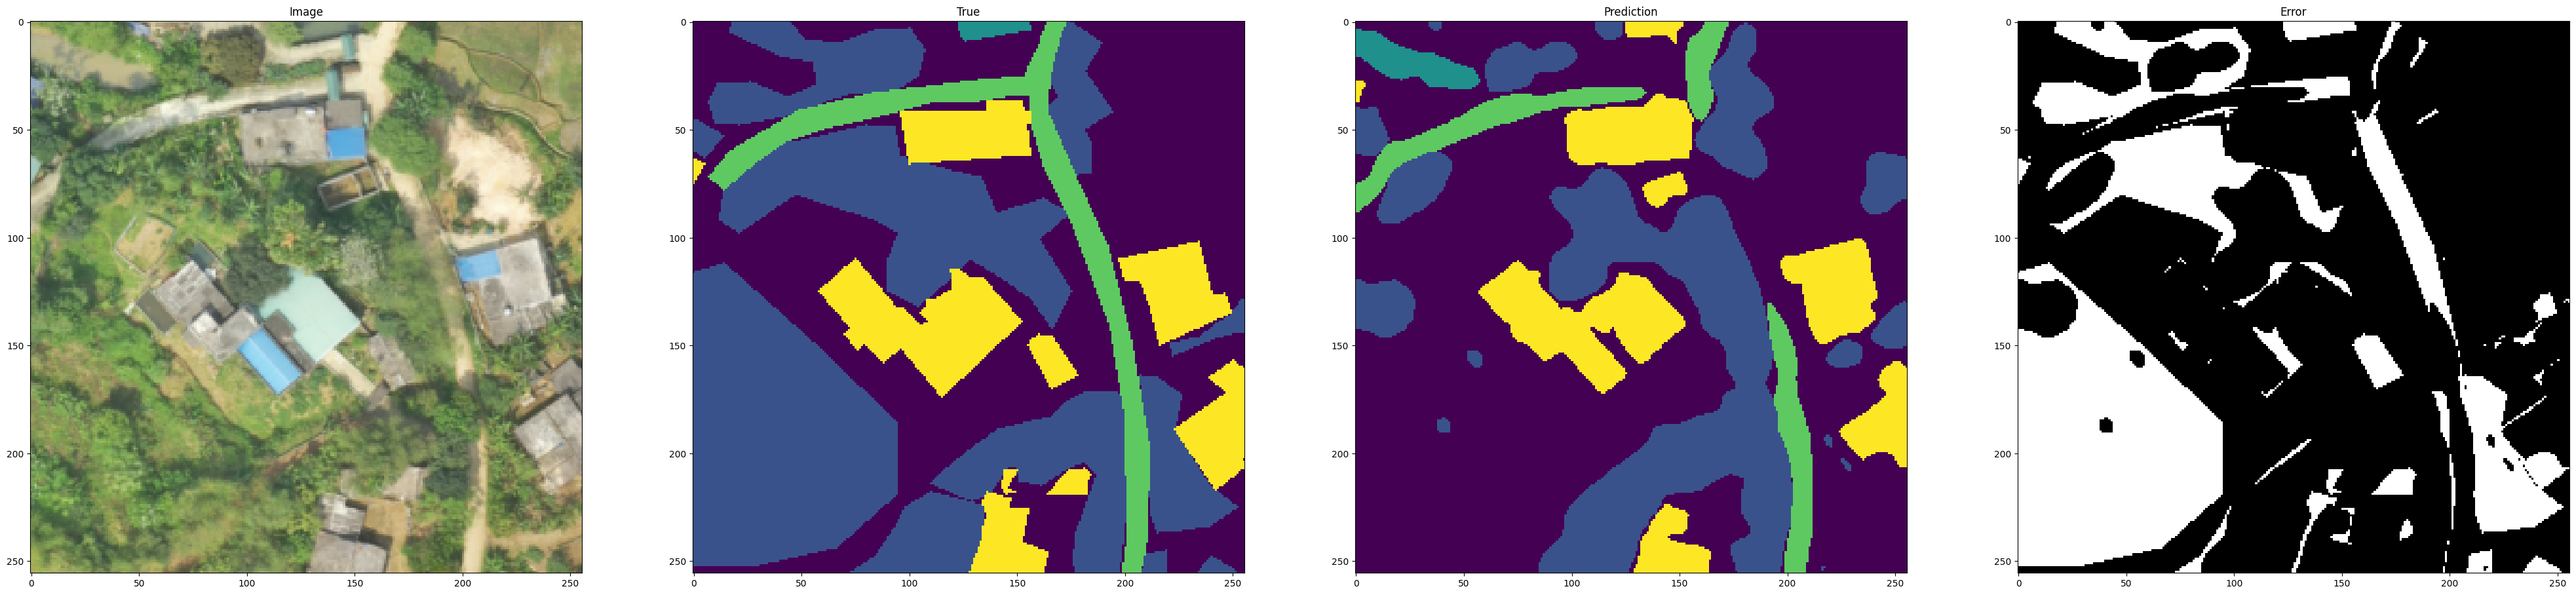

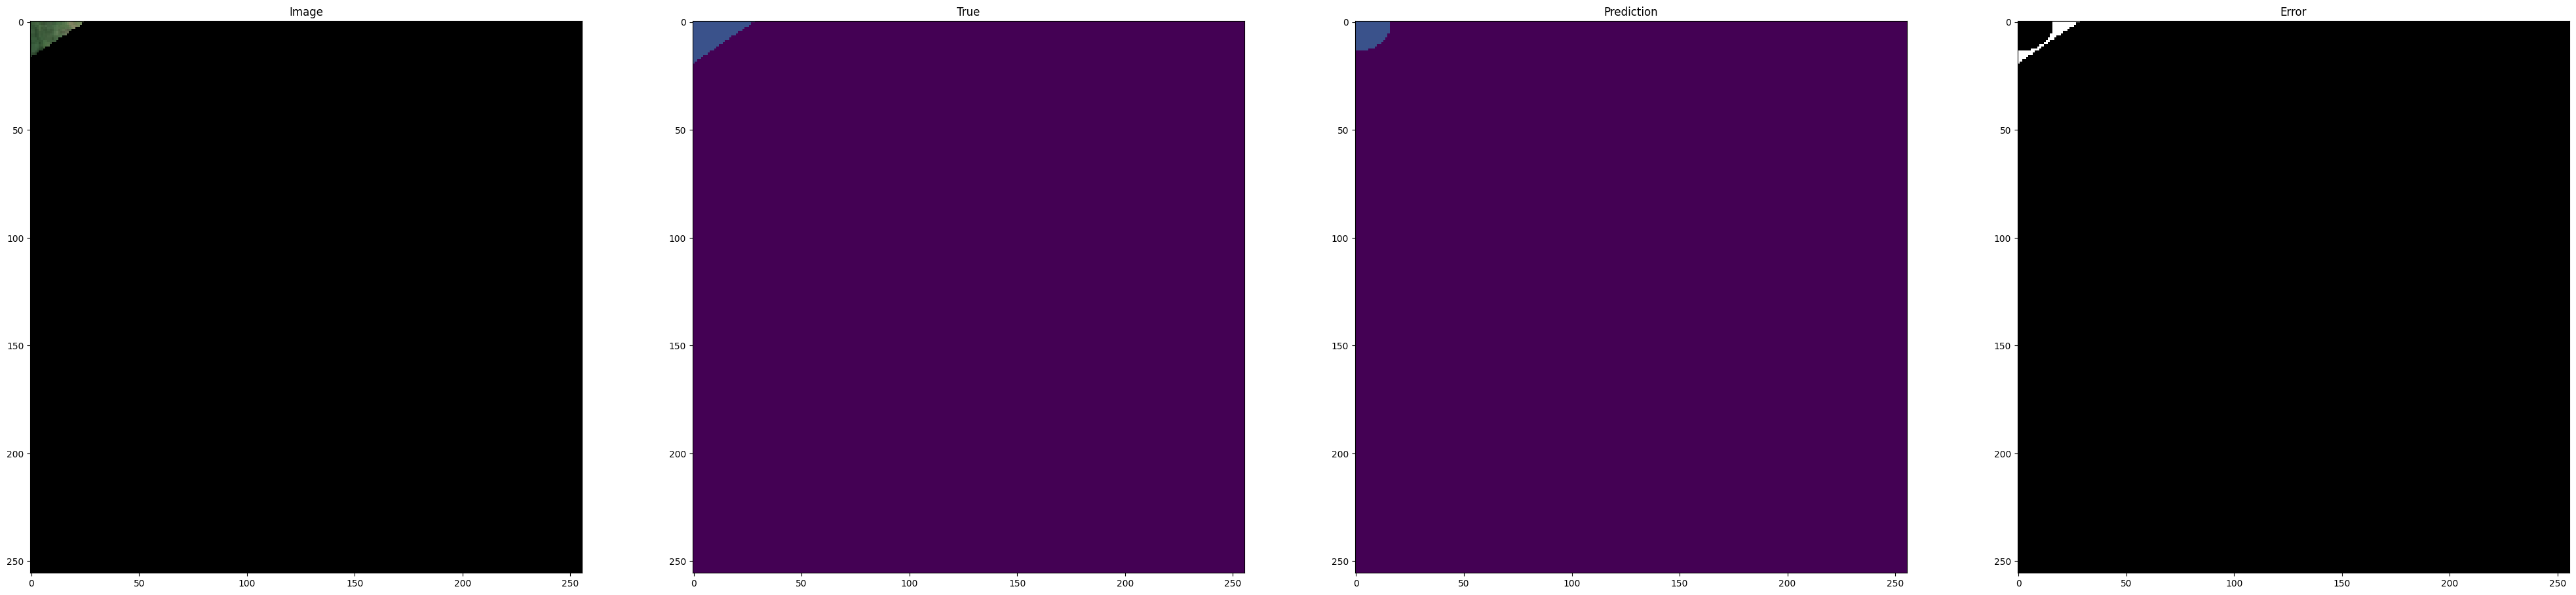

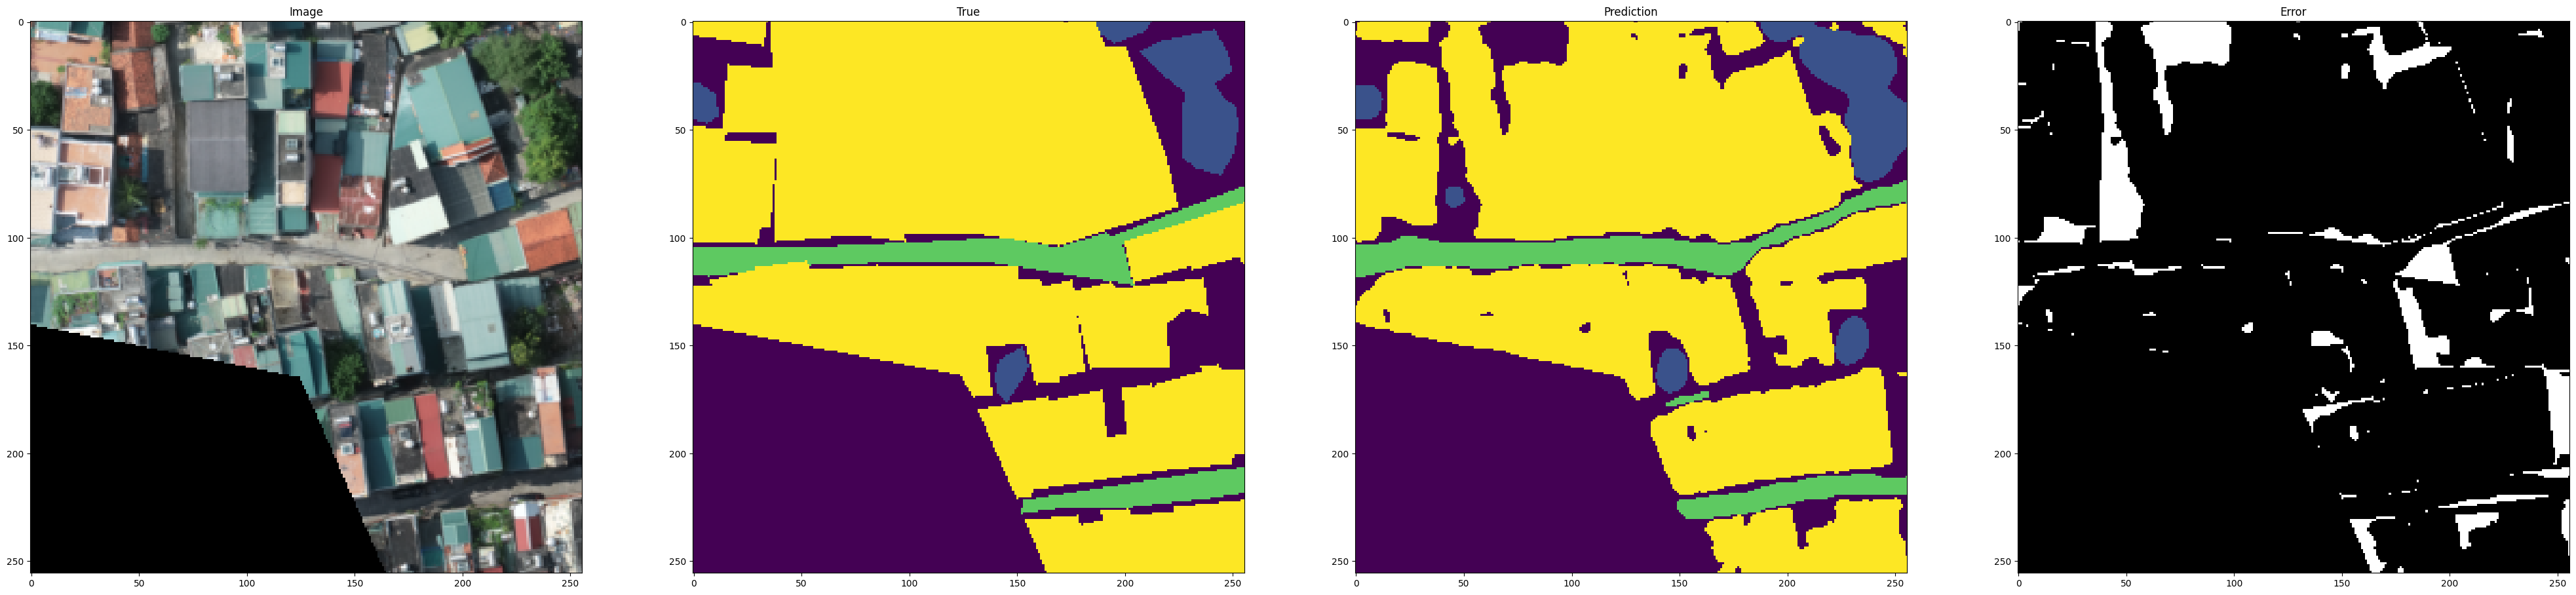

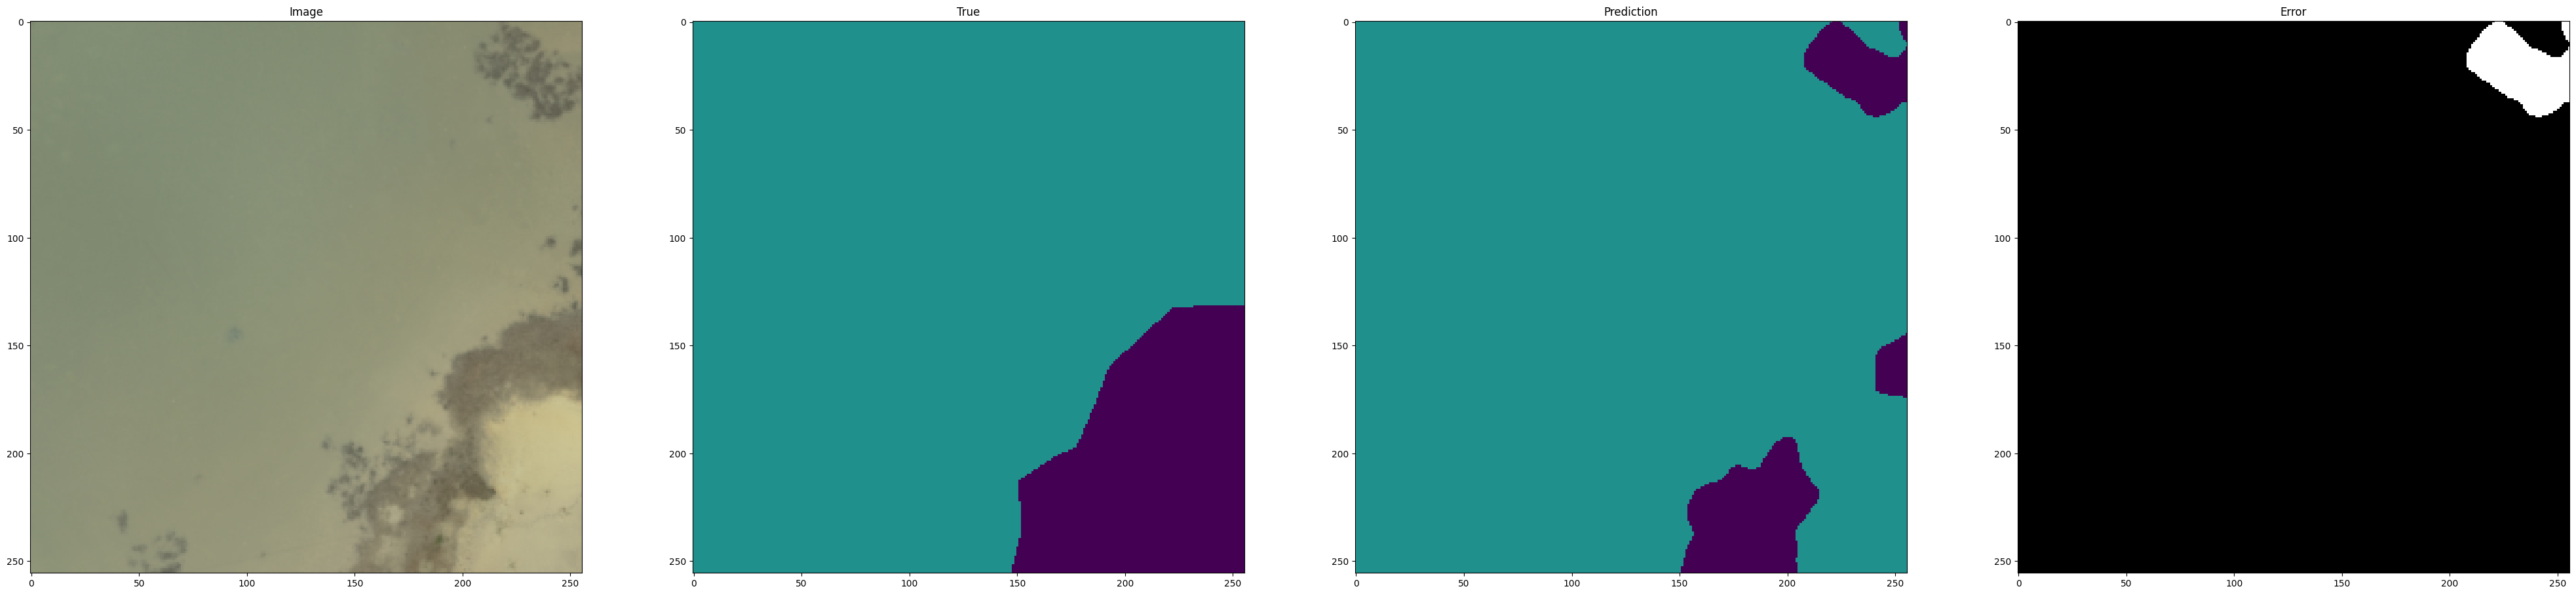

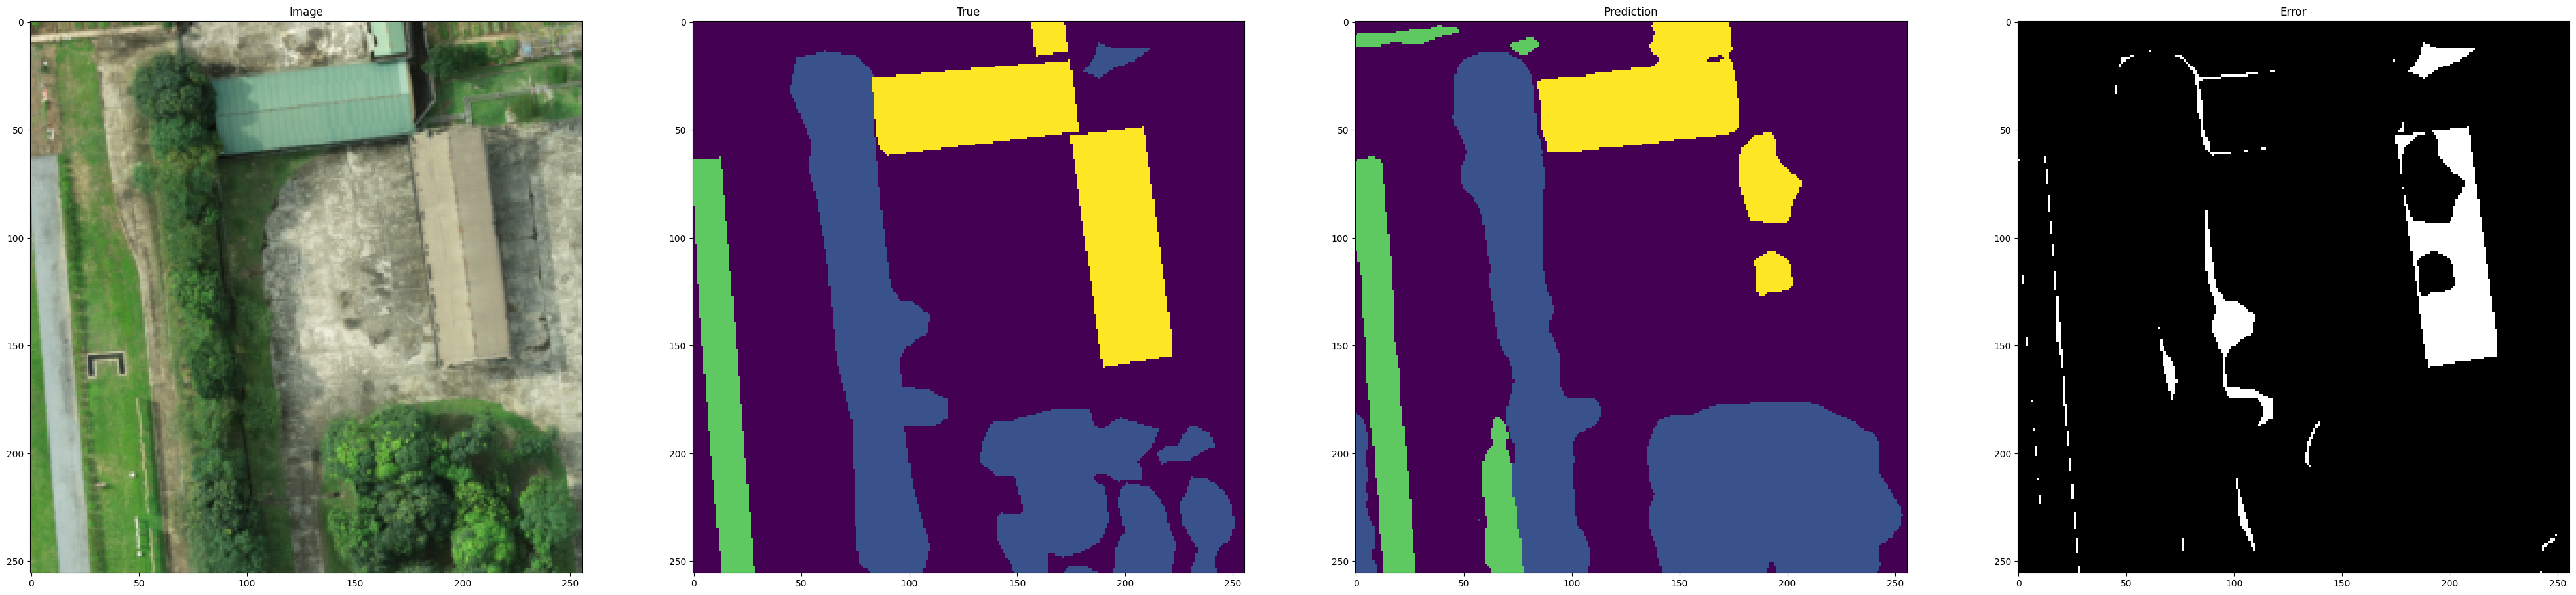

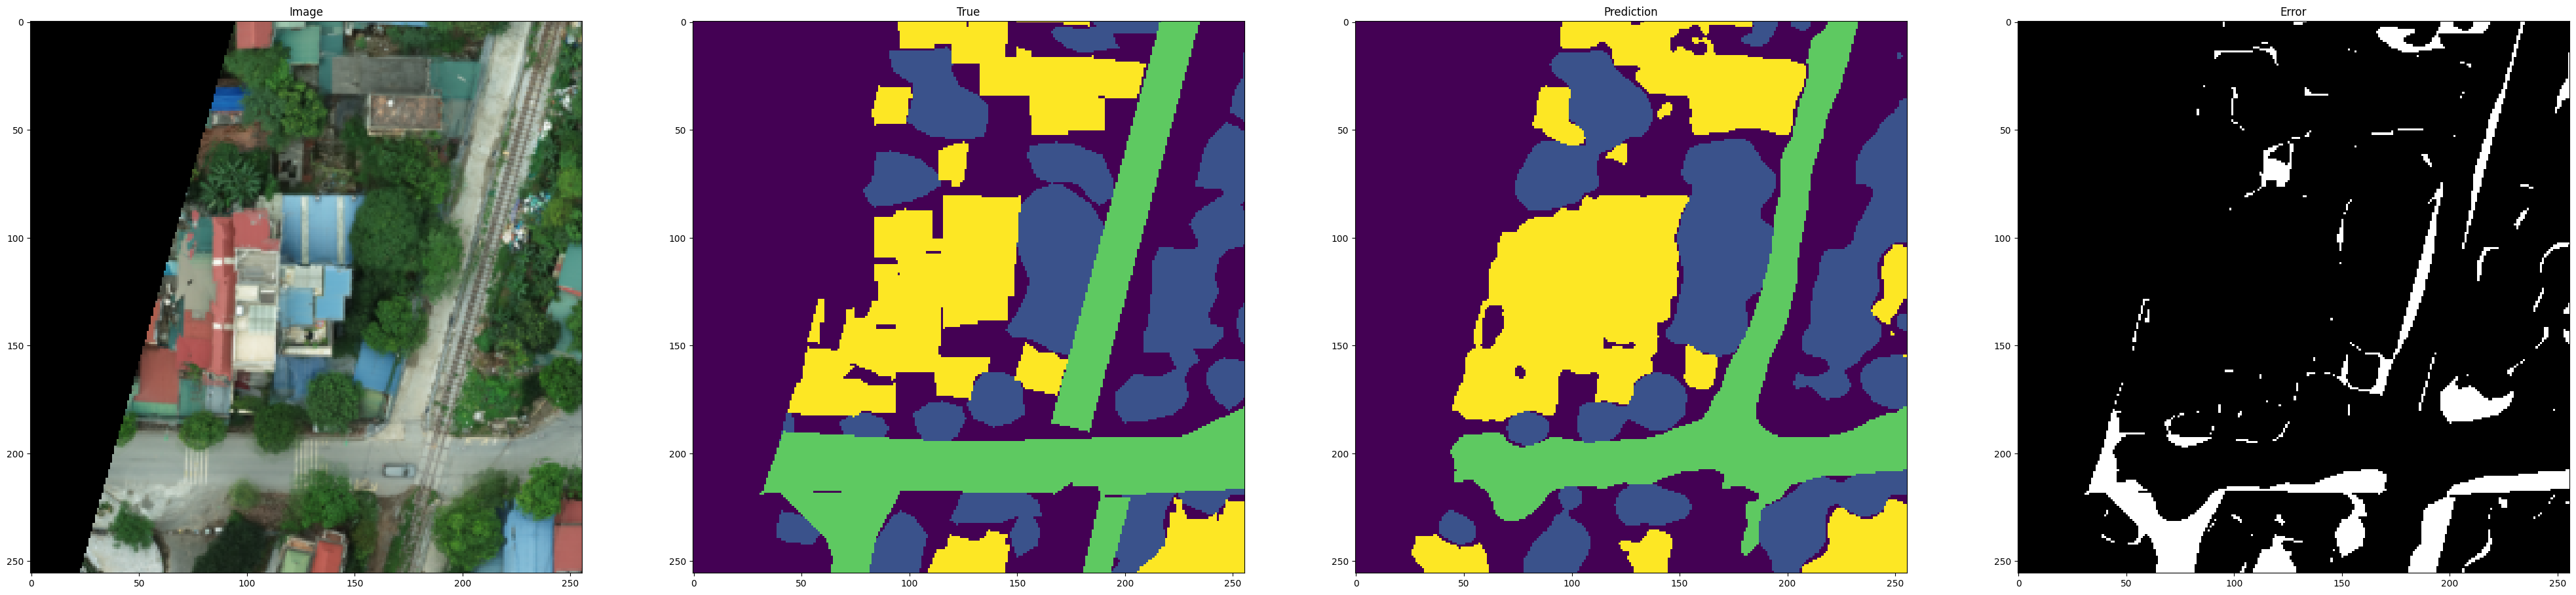

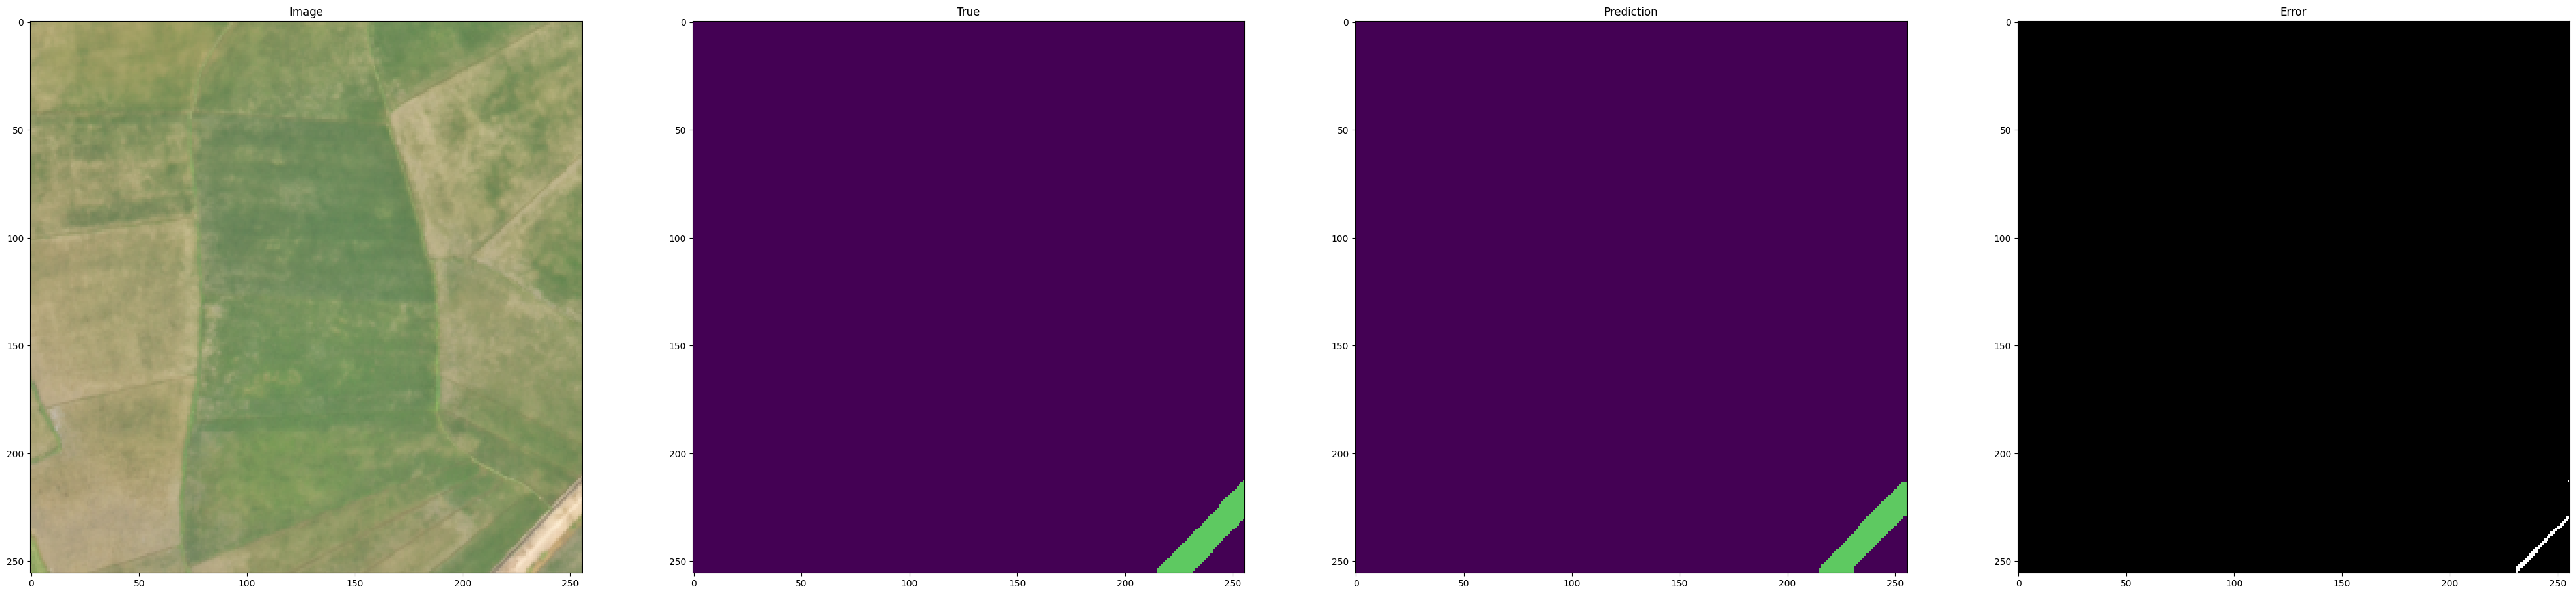

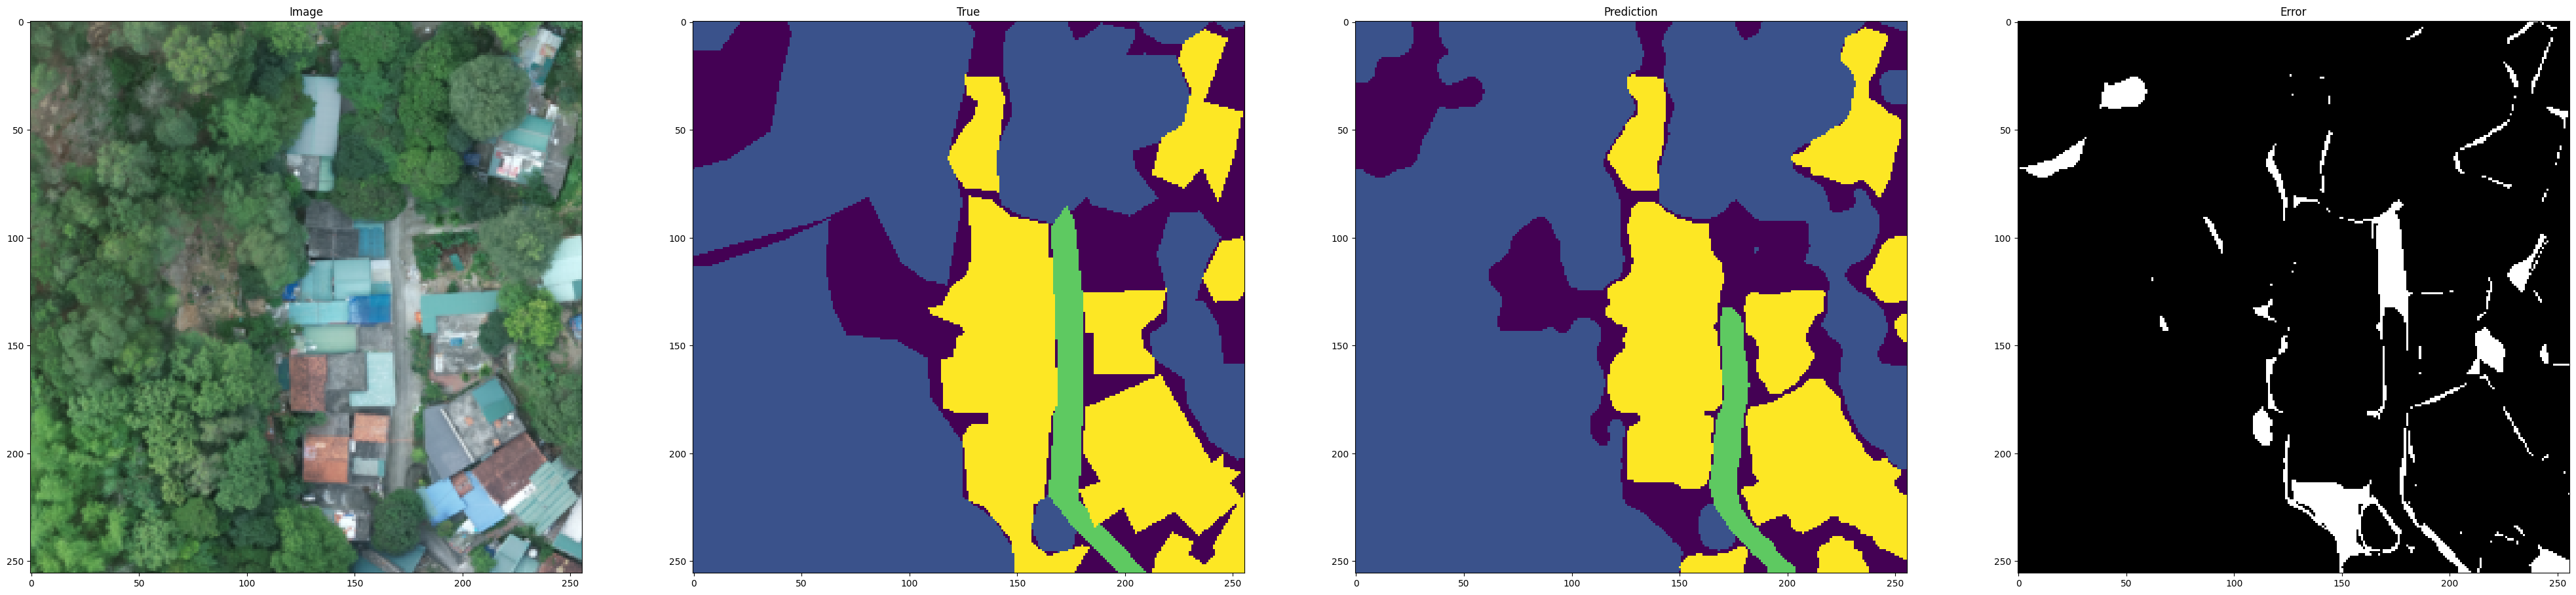

In [38]:
vmin = 0
vmax = 4

for i in range(25):

    image_number = random.randint(0, X_test.shape[0] - 1)

    plt.figure(figsize=(50, 12.5))

    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])

    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)

    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)  # convert to 0-5 classes

    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype('uint8')
    plt.imshow(error, cmap='gray')

    # print(prediction.shape)
    # print(prediction)
    # print(true.shape)
    # print(true)


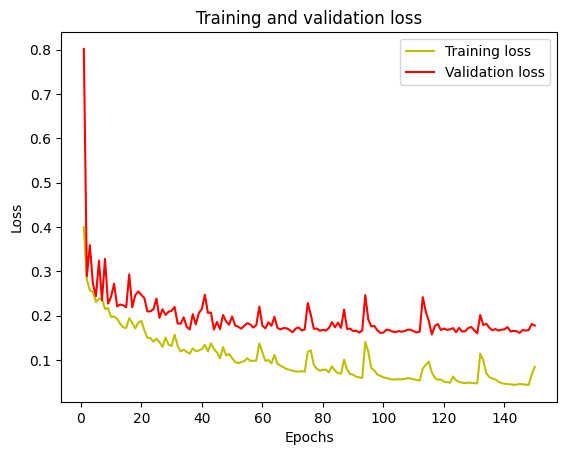

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

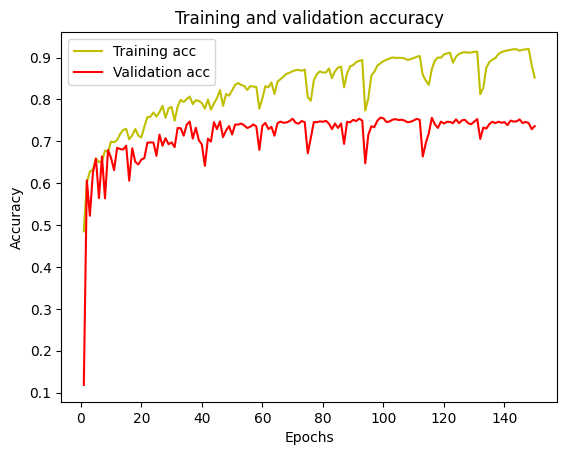

In [20]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
model.save('unet_model_with_focal_loss_resnet34_backbone.keras')

In [29]:
X_pred = []
X_label = []
for i in range(len(X_test)):
  true = y_test[i].argmax(axis=2)
  prediction = model.predict(np.expand_dims(X_test[i], 0))[0].argmax(axis=2)
  X_pred.append(prediction)
  X_label.append(true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [30]:
X_label = np.array(X_label)
X_pred = np.array(X_pred)

In [31]:
def calculate_iou(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = []

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores.append(0.0)  # Handle the case of no instances of a class
        else:
            iou_scores.append(intersection / union)

    return np.mean(iou_scores)

In [32]:
def calculate_iou_for_each_class(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = {}

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores[class_id] = 0.0  # Handle the case of no instances of a class
        else:
            iou_scores[class_id] = intersection / union

    return iou_scores


iou_scores = calculate_iou_for_each_class(X_label, X_pred)
for class_id, iou in iou_scores.items():
    print("IoU for class", class_id, ":", iou)


IoU for class 0 : 0.8535398692216707
IoU for class 1 : 0.8700961623317731
IoU for class 2 : 0.9205280449816096
IoU for class 3 : 0.5665917154260048
IoU for class 4 : 0.7198207731587394


In [33]:
miou = calculate_iou(X_label, X_pred)
print("Mean IoU:", miou)

Mean IoU: 0.7861153130239595
